In [85]:
import numpy as np
import cmath
import matplotlib.pyplot as plt

In [86]:
def coefficients(e, c0, p0, Ka, Kc):
    d = c0**2 * e * Ka
    c = -c0**2 * Ka + c0 * e * (-2 * Ka + Kc) - c0 * Kc * p0
    b = -c0 * (-2 * Ka + Kc) + e * (Ka + (-1 + Kc) * Kc) - Kc * (-1 + 2 * Kc) * p0
    a = -Ka - (-1 + Kc) * Kc
    return(np.array([a, b, c, d]))

In [87]:
def  my_cubic_solve(array):
    roots = np.roots(array)
    real_roots = []
    for i in roots:
        if (i.imag == 0):
            real_roots.append(i.real)
    return (np.array(real_roots))

In [88]:
def tdmc(cp, c0, p0, Ka, Kc):
    c = c0  -  cp
    t = (cp**2  *  Kc**2  *  p0) / (c0**2 * Ka + c0 * cp * ( -2 * Ka + Kc) + cp**2 * (Ka + ( -1 + Kc) * Kc))
    d = ((c0 - cp) * cp * Kc * p0) / (c0**2 * Ka + c0 * cp * ( -2 * Ka + Kc) + cp**2 * (Ka + ( -1 + Kc) * Kc))
    m = ((c0 - cp)**2 * Ka * p0) / (c0**2 * Ka + c0 * cp * ( -2 * Ka + Kc) + cp**2 * (Ka + ( -1 + Kc) * Kc))
    return(t, d, m, c)

In [89]:
def equilibr_ck(k, c0, t, d):
    crp = c0 * t / (d * k + t)
    cr = c0 - crp
    return (cr, crp)

In [90]:
def tdm(p, z):
    atp = ( 3*z + p - (p*p + 6*p*z - 3*z*z)**0.5 ) / 6
    adp = z - 2*atp
    amp = p - z + atp
    return(atp, adp, amp)

In [91]:
def u_atpase(a, atp):
    return (a * atp)

def u_hk(a, atp, g6p):
	return (a * (atp/1) / (1 + atp/1 + g6p/0.0055))

def u_pgi(a, g6p, f6p):
	k1, k2, k3 = 3, 0.3, 0.2
	return (a * (g6p-f6p*k1)/k2/(1+g6p/k2+f6p/k3))

def u_pfk(a, atp, amp, f6p):
	az = (1+atp/0.195)/(1+amp/0.01)/(1+f6p/3.7e-4)
	zn = 1 + 1e8 * az**4
	ch = a * f6p / (f6p+0.1) * atp/(atp+2) * (1/(1+amp/0.01)+2*amp/(amp+0.01))
	return (1.1 * ch/zn)

def u_ald(a, fdp, dap, gap):
	k1, k2, k3 = 2e-4, 1.2e-5, 1e-2
	k4, k5, k6, k7 = 3.2e-2, 2.1e-3, 2, 6.5e-2
	x = fdp/k1 - dap*gap/k2
	y = 1 + fdp/k3 + dap/k4 + gap/k5 + fdp*dap/k3/k4 + dap*dap/k4/k6 + dap*gap/k4/k7
	return (a * x / y)
	# Aald_eff = Aald * k3 * k4 / (k1 * (DAP + k4))

def u_tpi(a, dap, gap):
	k1, k2, k3 = 8.2e-1, 0.45, 4.3e-1
	return (a*(dap-gap/k2)/k1/(1+dap/k1+gap/k3))

def u_gapd(a, gap, nad, pi, dpg13, nadh):
	k1, k2, k3 = 0.13, 0.13, 3.4
	k4, k5, k6 = 0.136, 1.25e-2, 2e-3
	tt1 = a * (gap*nad*pi - dpg13*nadh/k4)/k1/k2/k3
	tt2 = (1+pi/k3)*(1+gap/k1+dpg13/k5)*(1+nad/k2+nadh/k6)
	return (tt1/tt2)
	# Эффективная активность GAPD при данных NADH, NAD, PI в сторону образования 1,3ДФГ
	# Agapd_eff = (Agapd * k6 * NAD * PI) / (k6 * NAD + k2 * (k6 + NADH)) / (k3 + PI)

def u_pgk(a, dpg13, adp, pg3, atp):
	ch1 = a * (dpg13*adp - pg3*atp/380)/2.2E-3/0.14
	aa = (0.3 + adp + 0.3*atp/0.27) / 0.14
	ab = (0.4 + atp + adp*0.4/0.14) / 0.27
	zn1 = (1 + atp/0.27 + adp/0.14 + aa*dpg13/2.2E-3 + ab*pg3/1.4)
	return (ch1 / zn1)

def u_pgm(a, pg3, pg2):
	k1, k2, k3 = 0.27, 0.24, 2e-2
	return (a * (pg3 - pg2/k2) / k1 / (1 + pg3/k1 + pg2/k3))

def u_eno(a, pg2, pep):
	# Старый вариант из статьи Эрлих 1985. ЕНО здесь была практически необратимая
	# k1, k2, k3 = 5.6e-2, 6.7, 2e-3
	k1, k2, k3 = 28e-3, 5, 50e-3 # обновил параметры из литературы
	return (a * (pg2 - pep/k2) / k1 / (1 + pg2/k1 + pep/k3))

def u_pk(a, pep, adp, atp):
	k2 = 0.415
	ch = a * pep*adp/0.05/k2
	zn = 1 + pep/0.05 + adp/k2 + atp/0.35 + pep*adp/0.05/k2
	return (ch / zn)

def u_ld(a, pyr, nadh, lac, nad):
	k1, k2, k3 = 2.2e-2, 7e-3, 426
	k4, k5, k6, k7 = 1.4e-1, 380, 0.1, 170
	temp1 = (pyr*nadh - lac*nad/k3)/k1/k2
	temp2 = k7*nad + k6*lac + nad*lac + k7/k1*pyr*nad
	temp3 = 1 + pyr/k1 + (nadh*k4 + pyr*nadh + k4/k5*lac*nadh)/k1/k2 + temp2/k5/k6
	return (a * temp1/temp3)

In [92]:
def u_gp_a(a, pi, g1p):
	kp, kg, keq = 4, 2.7, 1/3
	# local keq = 1/12
	return (a * kg * (pi - g1p / keq) / (kg * kp + kg * pi + kp * g1p))


def u_gp_b(a, pi, g1p, amp):
	
	keq = 1/3 
	
	# local kp = 4 * (amp + 0.1) / 1.1 / amp
	# local kg = 2.7 * (amp + 0.1) / 2 / amp
	# local af = a * amp / (amp + 0.02)
	# return af * (pi * keq - g1p) / (kp * g1p + kg * pi + kp * kg)
	
	# local a, b = 7.2, 1.26
	# local c, d = 0.203, 0.7
	# local e, f = 22.7, 0.0139
	# local kp = a / amp + b
	# local kg = c / amp + d
	# local ar = e * amp / (amp + f)
	# local arn = ar / e
	# return a * arn * kp * (keq * pi - g1p) / (kp * g1p + kg * pi + kp * kg) 

	kg = 0.172 / amp + 1.11
	ar = amp / (amp + 0.0104)
	return (ar / kg * ( keq * pi - g1p ))



def u_pgcm(a, g1p, g6p):
	k1, k6, keq = 8.5e-3, 50e-3, 17
	return (a * k6 * (g1p - g6p / keq) / (k1 * k6 + k6 * g1p + k1 * g6p))

def u_gp_a_palm(a, pi, g1p, g6p, amp):
	n = 2
	krpi = 2.08
	krg1p = 0.67
	kramp = 3.4e-3
	krg6p = 7.4
	lu = 5.9
	kupi = 4.3
	kug1p = 82
	kug6p = 0.56
  
	v1 = a*n*pi/krpi*(1 + pi/krpi + g1p/krg1p)**(n - 1)
	v2 = (1 + pi/krpi + g1p/krg1p)**n + lu*(1 + pi/kupi + g1p/kug1p)**n*(1 + g6p/kug6p)**n/(1 + amp/kramp + g6p/krg6p)**n

	return (a * v1 / v2)

In [93]:
import numpy as np
from scipy.optimize import fsolve
from sympy import symbols, Eq, solve

In [376]:
k_ak = 1
a_pgi = 360
a_ald = 76
a_gapd =690
a_pgm = 1100
a_pk = 120
a_ld = 550
a_tpi = 19522
a_pgk = 2115
a_eno = 204

# Glycolytic intermediates quantities in 1L of erythrocytes, mM
g6p = 73.1e-03
f6p = 23.9e-03
fdp = 7.49e-03
dap = 31.79e-03
gap = 14.1e-03
dpg13 = 0.734e-03
pg3 = 45.3e-03
pg2 = 10.7e-03
pep = 9.82e-03
pyr, lac = 70e-3, 1.2
po4 = 1
nad_0, nadh = 50e-3, 2e-03

a_gp_a, a_gp_b = 5000, 5000
a_pgcm = 4200
g1p = 0.05
ACT = 100

k_ck, c_0 = 5, 30
atp, amp = 5, 0.02
# активности ГК и ФФК для мышцы, по данным Витвицкого
# усреднённые по человеку и кролику
a_hk = 60
a_pfk = 4000
v_0 = 10
#v_0 = 500

ACT_gapd, ACT_pgk, ACT_pgm, ACT_eno, ACT_pk, ACT_ld = 1, 1, 1, 1, 1, 1

In [377]:
def func(y):    
    
    f6p_ = y[0]
    fdp_ = y[1]
    dap_ = y[2]
    gap_ = y[3]
    dpg13_ = y[4]
    pg3_ = y[5]
    pg2_ = y[6]
    pep_ = y[7]
    nadh_ = y[8]
    g6p_ = y[9]
    g1p_ = y[10]

    return(u_pgi(a_pgi, g6p_, f6p_) - u_pfk(a_pfk, atp, amp, f6p_),
           u_pfk(a_pfk, atp, amp, f6p_) - u_ald(a_ald, fdp_, dap_, gap_),
           u_ald(a_ald, fdp_, dap_, gap_) - u_tpi(a_tpi, dap_, gap_),
           u_tpi(a_tpi, dap_, gap_) + u_ald(a_ald, fdp_, dap_, gap_) - u_gapd(a_gapd * ACT, gap_, nad, po4, dpg13_, nadh_),
           u_gapd(a_gapd * ACT, gap_, nad, po4, dpg13_, nadh_) - u_pgk(a_pgk * ACT, dpg13_, adp, pg3_, atp),
           u_pgk(a_pgk * ACT, dpg13_, adp, pg3_, atp) - u_pgm(a_pgm * ACT, pg3_, pg2_),
           u_pgm(a_pgm * ACT, pg3_, pg2_) - u_eno(a_eno * ACT, pg2_, pep_),
           u_eno(a_eno * ACT, pg2_, pep_) - u_pk(a_pk * ACT, pep_, adp, atp),
           u_gapd(a_gapd * ACT, gap_, nad, po4, dpg13_, nadh_) - u_ld(a_ld * ACT, pyr, nadh_, lac, nad),
           u_hk(a_hk, atp, g6p_) - u_pgi(a_pgi, g6p_, f6p_) + u_pgcm(a_pgcm, g1p_, g6p_),
           u_gp_a(a_gp_a, po4, g1p_) - u_pgcm(a_pgcm, g1p_, g6p_))


In [378]:
nad = nad_0 - nadh
adp = ( atp * amp / k_ak )**0.5
p_0 = atp + adp + amp

a_atpase = v_0 / u_atpase(1, atp) 

cr, crp = equilibr_ck(k_ck, c_0, atp, adp) 
ep = 2 * atp + adp + crp
po4_0 = g1p + g6p + f6p + 2*fdp + dap + gap + 2*dpg13 + pg3 + pg2 + pep + ep + po4 

In [379]:
po4_0

34.38379356545557

In [380]:
ep_pool = np.linspace(0, 2 * p_0 + c_0 - 6.5, 5000)

In [381]:
ep_pool[3000]

20.50757483418704

In [382]:
y0 = [f6p, fdp, dap, gap, dpg13, pg3, pg2, pep, nadh, g6p, g1p]

In [383]:
ep_pool[:0:-1]

array([3.41724555e+01, 3.41656197e+01, 3.41587838e+01, ...,
       2.05075748e-02, 1.36717166e-02, 6.83585828e-03])

In [384]:
res = [y0]
atp_p = []
adp_p = []
amp_p = []
po4_p = []
for ep in ep_pool[3000::-1]:
    nad = nad_0 - nadh
    po4_up = g1p + g6p + f6p + 2*fdp + dap + gap
    po4_down = 2*dpg13 + pg3 + pg2 + pep
    po4 = po4_0 - ( po4_up + po4_down + ep )
    crp = float(my_cubic_solve(coefficients(ep, c_0, p_0, k_ak, k_ck)))
    atp, adp, amp, cr = tdmc(crp, c_0, p_0, k_ak, k_ck)
    root = fsolve(func, res[-1], full_output = True)
    if (root[2] == 1 and (np.isclose(func(root[0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])).all()):
        res.append(root[0])
        atp_p.append(atp)
        adp_p.append(adp)
        amp_p.append(amp)
        po4_p.append(po4)
        
res = res[:0:-1]
atp_p = atp_p[::-1]
adp_p = adp_p[::-1]
amp_p = amp_p[::-1]
po4_p = po4_p[::-1]

for ep in ep_pool[3000::1]:
    nad = nad_0 - nadh
    po4_up = g1p + g6p + f6p + 2*fdp + dap + gap
    po4_down = 2*dpg13 + pg3 + pg2 + pep
    po4 = po4_0 - ( po4_up + po4_down + ep )
    crp = float(my_cubic_solve(coefficients(ep, c_0, p_0, k_ak, k_ck)))
    atp, adp, amp, cr = tdmc(crp, c_0, p_0, k_ak, k_ck)
    root = fsolve(func, res[-1], full_output = True)
    if (root[2] == 1 and (np.isclose(func(root[0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])).all()):
        res.append(root[0])
        atp_p.append(atp)
        adp_p.append(adp)
        amp_p.append(amp)
        po4_p.append(po4)

In [385]:
res1 = [y0]
atp_p1 = []
adp_p1 = []
amp_p1 = []
po4_p1 = []
for ep in np.linspace(30, 2 * p_0 + c_0 - 6.5, 50000)[::-1]:
    nad = nad_0 - nadh
    po4_up = g1p + g6p + f6p + 2*fdp + dap + gap
    po4_down = 2*dpg13 + pg3 + pg2 + pep
    po4 = po4_0 - ( po4_up + po4_down + ep )
    crp = float(my_cubic_solve(coefficients(ep, c_0, p_0, k_ak, k_ck)))
    atp, adp, amp, cr = tdmc(crp, c_0, p_0, k_ak, k_ck)
    root = fsolve(func, res[-1], full_output = True)
    if (root[2] == 1 and (np.isclose(func(root[0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])).all()):
        res1.append(root[0])
        atp_p1.append(atp)
        adp_p1.append(adp)
        amp_p1.append(amp)
        po4_p1.append(po4)

res = []
atp_p = []
adp_p = []
amp_p = []
for ep in ep_pool:
    nad = nad_0 - nadh
    po4_up = g1p + g6p + f6p + 2*fdp + dap + gap
    po4_down = 2*dpg13 + pg3 + pg2 + pep
    po4 = po4_0 - ( po4_up + po4_down + ep )
    crp = float(my_cubic_solve(coefficients(ep, c_0, p_0, k_ak, k_ck)))
    atp, adp, amp, cr = tdmc(crp, c_0, p_0, k_ak, k_ck)
    root = fsolve(func, [0,0,0,0,0,0,0,0,0,0,0])
    if (np.isclose(func(root), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] , atol=0.0)).all():
        res.append(fsolve(func, [0,0,0,0,0,0,0,0,0,0,0]))
        atp_p.append(atp)
        adp_p.append(adp)
        amp_p.append(amp)

In [386]:
f6p = np.array(res)[:,0]
fdp = np.array(res)[:,1]
dap = np.array(res)[:,2]
gap = np.array(res)[:,3]
dpg13 = np.array(res)[:,4]
pg3 = np.array(res)[:,5]
pg2 = np.array(res)[:,6]
pep = np.array(res) [:,7]
nadh = np.array(res)[:,8]
g6p = np.array(res)[:,9]
g1p = np.array(res)[:,10]

In [387]:
f6p = np.append(f6p, np.array(res1)[1:, 0])
fdp = np.append(fdp, np.array(res1)[1:, 1])
dap = np.append(dap, np.array(res1)[1:, 2])
gap = np.append(gap, np.array(res1)[1:, 3])
dpg13 = np.append(dpg13, np.array(res1)[1:, 4])
pg3 = np.append(pg3, np.array(res1)[1:, 5])
pg2 = np.append(pg2, np.array(res1)[1:, 6])
pep = np.append(pep, np.array(res1)[1:, 7])
nadh = np.append(nadh, np.array(res1)[1:, 8])
g6p = np.append(g6p, np.array(res1)[1:, 9])
g1p = np.append(g1p, np.array(res1)[1:, 10])

In [388]:
atp_p += atp_p1
adp_p += adp_p1
amp_p += amp_p1
po4_p += po4_p1

plt.figure(figsize = (20, 10))
plt.plot(atp_p,fdp)
plt.plot(atp_p,f6p)
plt.plot(atp_p,dap)
plt.plot(atp_p,gap)
plt.plot(atp_p,dpg13)
plt.plot(atp_p,pg3)
plt.plot(atp_p,pg2)
plt.plot(atp_p,pep)
plt.plot(atp_p,nadh)
plt.plot(atp_p,g6p )
plt.plot(atp_p,g1p )
plt.legend(['fdp', 'f6p', 'dap', 'gap', 'dpg13', 'pg3', 'pg2', 'pep', 'nadh', 'g6p', 'g1p'], fontsize = 20)
plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('atp', size = 20)
plt.ylabel('concentration', size = 20)
#plt.xlim(0, 5)
#plt.ylim(0, 200)
plt.show()

plt.figure(figsize = (20, 10))
plt.scatter(atp_p,fdp)
plt.scatter(atp_p,f6p)
plt.scatter(atp_p,dap)
plt.scatter(atp_p,gap)
plt.scatter(atp_p,dpg13)
plt.scatter(atp_p,pg3)
plt.scatter(atp_p,pg2)
plt.scatter(atp_p,pep)
plt.scatter(atp_p,nadh)
plt.scatter(atp_p,g6p )
plt.scatter(atp_p,g1p )
plt.legend(['fdp', 'f6p', 'dap', 'gap', 'dpg13', 'pg3', 'pg2', 'pep', 'nadh', 'g6p', 'g1p'], fontsize = 20)
plt.title('Установление стационарного состояния', size = 20)
plt.xlabel('atp', size = 20)
plt.ylabel('concentration', size = 20)
#plt.xlim(0, 5)
#plt.ylim(0, 200)
plt.show()

In [389]:
v_pfk_atp = []
v_hk_atp = []
v_pgk_atp = []
v_pk_atp = []
for ix, atp in enumerate(atp_p):
    v_pfk_atp.append(u_pfk(a_pfk, atp, amp_p[ix], f6p[ix]))
    v_hk_atp.append(u_hk(a_hk, atp, g6p[ix]))
    v_pgk_atp.append(u_pgk(a_pgk * ACT, dpg13[ix], adp_p[ix], pg3[ix], atp))
    v_pk_atp.append(u_pk(a_pk * ACT, pep[ix], adp_p[ix], atp))

In [390]:
import pandas as pd

In [391]:
def f_plot(x, y):
    plot_1 = pd.DataFrame({'x':x,'y':y})
    plot_1 = plot_1.sort_values('x')
    plt.plot(plot_1['x'],plot_1['y'])

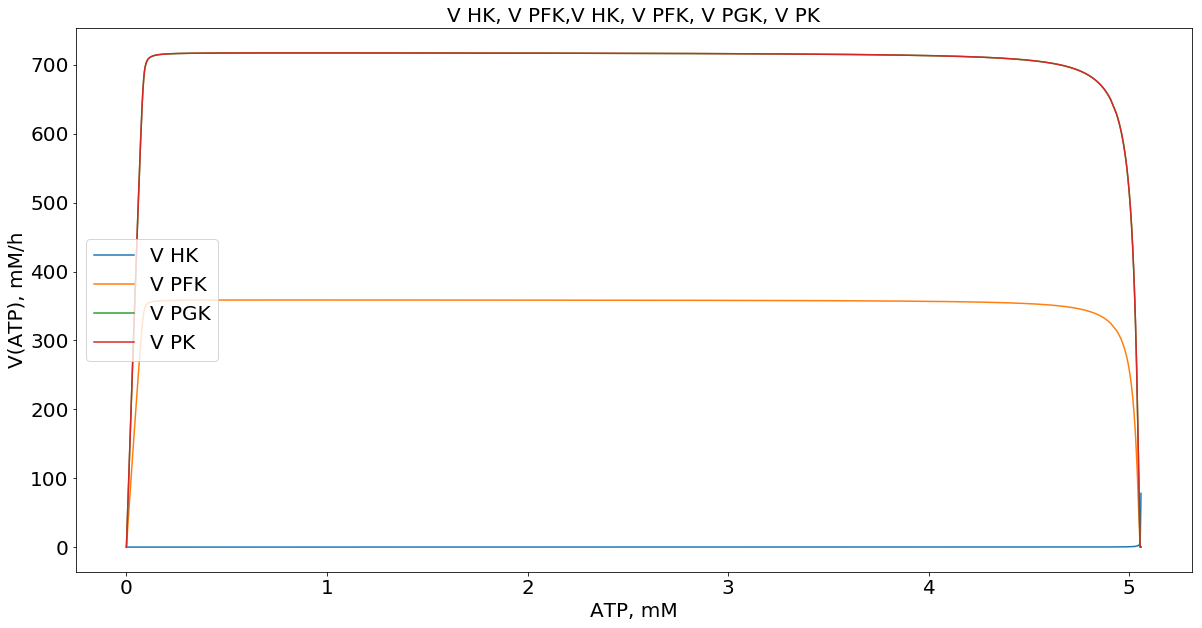

In [392]:
plt.figure(figsize = (20, 10))

plot_1 = pd.DataFrame({'x':atp_p,'y':v_hk_atp})
plot_1 = plot_1.sort_values('x')
plt.plot(plot_1['x'],plot_1['y'])
# plt.plot(atp_p,np.array(v_hk_atp))

plot_2 = pd.DataFrame({'x':atp_p,'y':v_pfk_atp})
plot_2 = plot_2.sort_values('x')
plt.plot(plot_2['x'],plot_2['y'])
# plt.plot(atp_p,np.array(v_pfk_atp))

plot_3 = pd.DataFrame({'x':atp_p,'y':v_pgk_atp})
plot_3 = plot_3.sort_values('x')
plt.plot(plot_3['x'],plot_3['y'])
# plt.plot(atp_p,np.array(v_pgk_atp))

plot_4 = pd.DataFrame({'x':atp_p,'y':v_pk_atp})
plot_4 = plot_4.sort_values('x')
plt.plot(plot_4['x'],plot_4['y'])
# plt.plot(atp_p,np.array(v_pk_atp),)

plt.title('V HK, V PFK,V HK, V PFK, V PGK, V PK', size = 20)
plt.xlabel('ATP, mM', size = 20)
plt.ylabel('V(ATP), mM/h', size = 20)
plt.legend(['V HK', 'V PFK', 'V PGK', 'V PK'], fontsize = 20)
# plt.xlim(0, 5.055)
# plt.ylim(0, 800)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

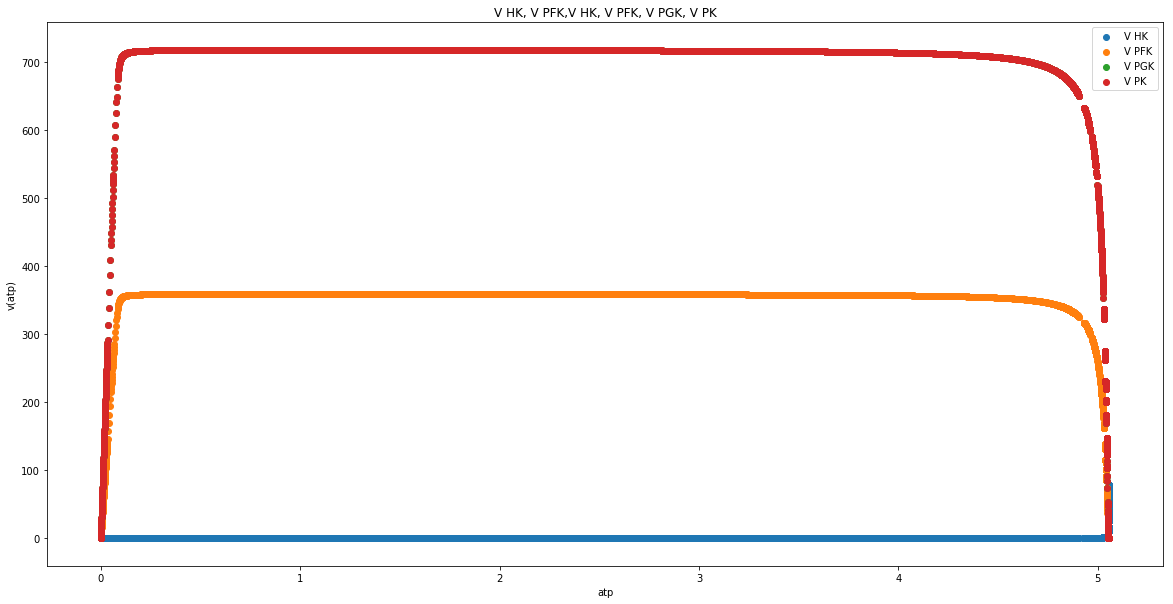

In [393]:
plt.figure(figsize = (20, 10))
plt.scatter(atp_p,np.array(v_hk_atp))
plt.scatter(atp_p,np.array(v_pfk_atp))
plt.scatter(atp_p,np.array(v_pgk_atp))
plt.scatter(atp_p,np.array(v_pk_atp))

plt.title('V HK, V PFK,V HK, V PFK, V PGK, V PK')
plt.xlabel('atp')
plt.ylabel('v(atp)')
plt.legend(['V HK', 'V PFK', 'V PGK', 'V PK'])
#plt.xlim(0, 5.5)
#plt.ylim(0, 1000)
plt.show()

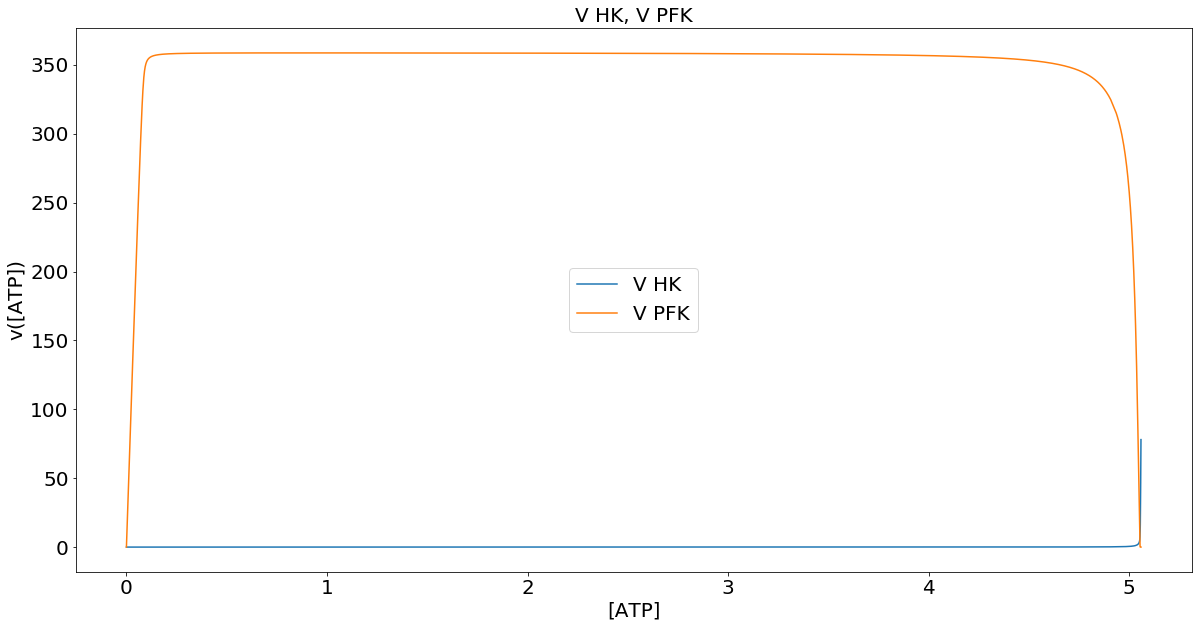

In [394]:
plt.figure(figsize = (20, 10))
f_plot(atp_p,np.array(v_hk_atp))
f_plot(atp_p,np.array(v_pfk_atp))
#plt.plot(atp_p,np.array(v_hk_atp), color = 'red')
#plt.plot(atp_p,np.array(v_pfk_atp), color = 'green')
plt.title('V HK, V PFK', size = 20)
plt.xlabel('[ATP]', size = 20)
plt.ylabel('v([ATP])', size = 20)
plt.legend(['V HK', 'V PFK'], fontsize = 20)
#plt.xlim(0, 5.055)
#plt.ylim(0, 500)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

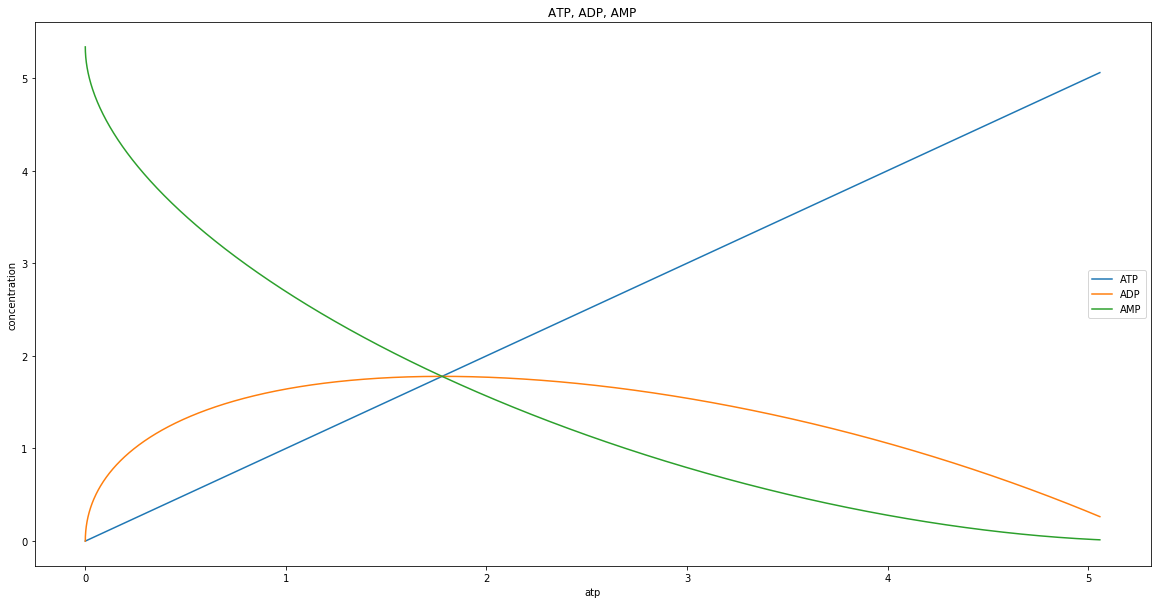

In [395]:
plt.figure(figsize = (20, 10))
f_plot(atp_p,atp_p)
f_plot(atp_p,adp_p)
f_plot(atp_p,amp_p)

plt.title('ATP, ADP, AMP')
plt.xlabel('atp')
plt.ylabel('concentration')
plt.legend(['ATP', 'ADP', 'AMP'])
plt.show()

In [396]:
v_production_atp = []
for ix, atp in enumerate(atp_p):
    v_production_atp.append(-v_hk_atp[ix] - v_pfk_atp[ix] + v_pgk_atp[ix] + v_pk_atp[ix])

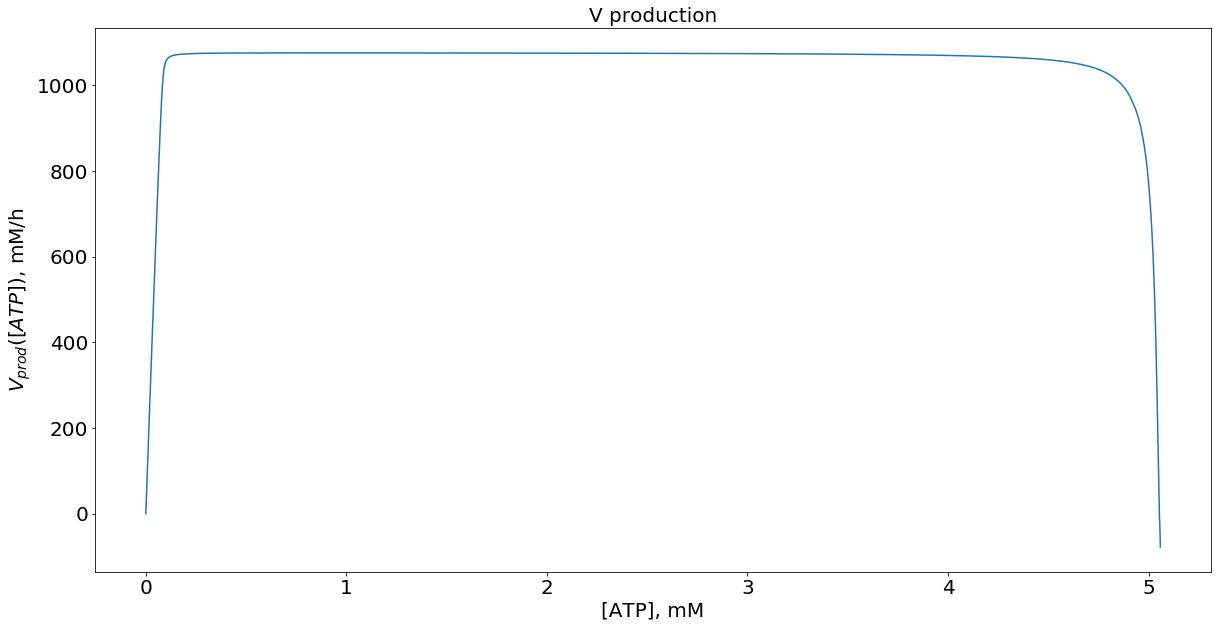

In [397]:
plt.figure(figsize = (20, 10))
f_plot(atp_p,np.array(v_production_atp))
plt.title('V production', size = 20)
plt.xlabel('[ATP], mM', size = 20)
plt.ylabel('$V_{prod}([ATP])$, mM/h', size = 20)
# plt.xlim(0, 5.055)
# plt.ylim(0, 1500)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

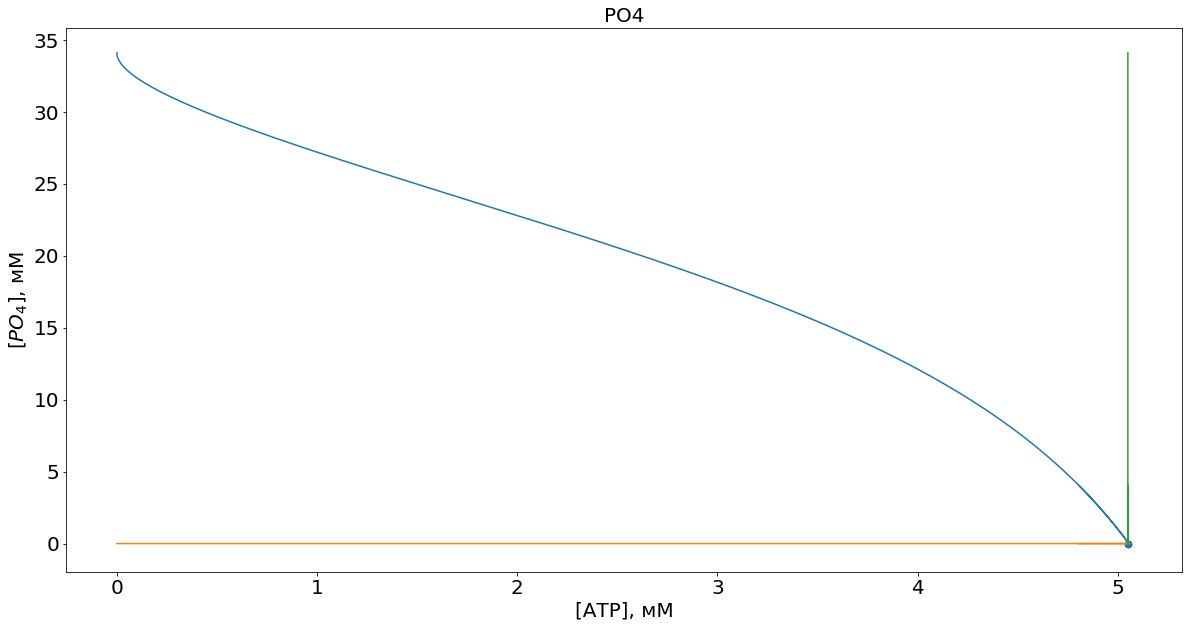

In [398]:
plt.figure(figsize = (20, 10))
plt.plot(atp_p,po4_p, )
plt.plot(atp_p, np.zeros(len(atp_p)))
plt.plot(np.linspace(5.05, 5.05, len(po4_p)), po4_p)
plt.scatter(5.05, 0, s = 50)

plt.title('PO4' , size = 20)
plt.xlabel('[ATP], мМ' , size = 20)
plt.ylabel('[$PO_4$], мМ' , size = 20)

plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

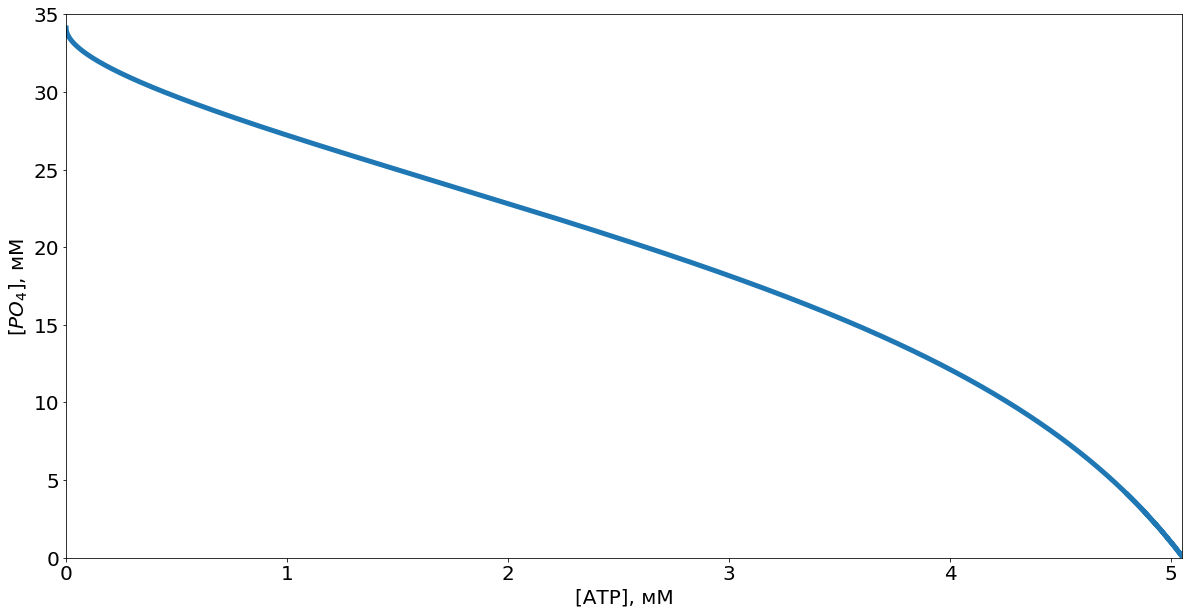

In [399]:
plt.figure(figsize = (20, 10))
plt.plot(atp_p,po4_p, linewidth=5)
#plt.plot(atp_p, np.zeros(len(atp_p)))
#plt.plot(np.linspace(5.05, 5.05, len(po4_p)), po4_p)
#plt.scatter(5.05, 0, s = 200)

#plt.title('PO4' , size = 20)
plt.xlabel('[ATP], мМ' , size = 20)
plt.ylabel('[$PO_4$], мМ' , size = 20)

plt.xlim(0, 5.05)
plt.ylim(0, 35)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

# Построим график зависимости $V_{HK}$ от концентрации АТФ при различных значениях активности GP

In [466]:
ep_pool = np.linspace(0, 2 * p_0 + c_0, 5000)

In [467]:
k_ak = 1
a_pgi = 360
a_ald = 76
a_gapd =690
a_pgm = 1100
a_pk = 120
a_ld = 550
a_tpi = 19522
a_pgk = 2115
a_eno = 204

# Glycolytic intermediates quantities in 1L of erythrocytes, mM
g6p = 73.1e-03
f6p = 23.9e-03
fdp = 7.49e-03
dap = 31.79e-03
gap = 14.1e-03
dpg13 = 0.734e-03
pg3 = 45.3e-03
pg2 = 10.7e-03
pep = 9.82e-03
pyr, lac = 70e-3, 1.2
po4 = 1
nad_0, nadh = 50e-3, 2e-03

a_gp_a = 0
a_gp_b = 5000
a_pgcm = 4200
g1p = 0.05
ACT = 100

k_ck, c_0 = 5, 30
atp, amp = 5, 0.02
# активности ГК и ФФК для мышцы, по данным Витвицкого
# усреднённые по человеку и кролику
a_hk = 60
a_pfk = 4000
v_0 = 10

ACT_gapd, ACT_pgk, ACT_pgm, ACT_eno, ACT_pk, ACT_ld = 1, 1, 1, 1, 1, 1

In [468]:
res = [y0]
atp_p = []
adp_p = []
amp_p = []
po4_p = []
for ep in ep_pool[3000::-1]:
    nad = nad_0 - nadh
    po4_up = g1p + g6p + f6p + 2*fdp + dap + gap
    po4_down = 2*dpg13 + pg3 + pg2 + pep
    po4 = po4_0 - ( po4_up + po4_down + ep )
    crp = float(my_cubic_solve(coefficients(ep, c_0, p_0, k_ak, k_ck)))
    atp, adp, amp, cr = tdmc(crp, c_0, p_0, k_ak, k_ck)
    root = fsolve(func, res[-1], full_output = True)
    if (root[2] == 1 and (np.isclose(func(root[0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])).all()):
        res.append(root[0])
        atp_p.append(atp)
        adp_p.append(adp)
        amp_p.append(amp)
        po4_p.append(po4)
        
res = res[:0:-1]
atp_p = atp_p[::-1]
adp_p = adp_p[::-1]
amp_p = amp_p[::-1]
po4_p = po4_p[::-1]

for ep in ep_pool[3000::1]:
    nad = nad_0 - nadh
    po4_up = g1p + g6p + f6p + 2*fdp + dap + gap
    po4_down = 2*dpg13 + pg3 + pg2 + pep
    po4 = po4_0 - ( po4_up + po4_down + ep )
    crp = float(my_cubic_solve(coefficients(ep, c_0, p_0, k_ak, k_ck)))
    atp, adp, amp, cr = tdmc(crp, c_0, p_0, k_ak, k_ck)
    root = fsolve(func, res[-1], full_output = True)
    if (root[2] == 1 and (np.isclose(func(root[0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])).all()):
        res.append(root[0])
        atp_p.append(atp)
        adp_p.append(adp)
        amp_p.append(amp)
        po4_p.append(po4)

In [469]:
f6p = np.array(res)[:,0]
fdp = np.array(res)[:,1]
dap = np.array(res)[:,2]
gap = np.array(res)[:,3]
dpg13 = np.array(res)[:,4]
pg3 = np.array(res)[:,5]
pg2 = np.array(res)[:,6]
pep = np.array(res) [:,7]
nadh = np.array(res)[:,8]
g6p = np.array(res)[:,9]
g1p = np.array(res)[:,10]

In [470]:
v_pfk_atp_0 = []
v_hk_atp_0 = []
v_pgk_atp_0 = []
v_pk_atp_0 = []
for ix, atp in enumerate(atp_p):
    v_pfk_atp_0.append(u_pfk(a_pfk, atp, amp_p[ix], f6p[ix]))
    v_hk_atp_0.append(u_hk(a_hk, atp, g6p[ix]))
    v_pgk_atp_0.append(u_pgk(a_pgk * ACT, dpg13[ix], adp_p[ix], pg3[ix], atp))
    v_pk_atp_0.append(u_pk(a_pk * ACT, pep[ix], adp_p[ix], atp))

In [471]:
v_production_atp_0 = []
for ix, atp in enumerate(atp_p):
    v_production_atp_0.append(-v_hk_atp_0[ix] - v_pfk_atp_0[ix] + v_pgk_atp_0[ix] + v_pk_atp_0[ix])

# Посмторим на значения концентраций метаболитов при [ATP] = 90% pool

In [477]:
atp_p[-1]

5.335108649716906

In [478]:
len(atp_p)

4832

In [487]:
atp_p[4180]

5.074157819236653

In [ ]:
g1p[4850]

In [488]:
v_production_atp_0[4180]

10.111381366179305

In [489]:
d1 = np.array([(f6p[4180]),\
            (fdp[4180]),\
            (dap[4180]),\
            (gap[4180]),\
            (dpg13[4180]),\
            (pg3[4180]),\
            (pg2[4180]),\
            (pep[4180]),\
            (nadh[4180]),\
            (g6p[4180]),\
            (g1p[4180]),
             atp_p[4180],
             adp_p[4180],
             amp_p[4180],
             po4_p[4180],
             v_production_atp_0[4180]])

In [490]:
d1

array([ 9.57947877e-02,  4.27984416e-05, -2.11621039e-03, -1.04737670e-03,
        5.61945777e-05,  1.02608768e-03,  2.40210342e-04,  1.12949701e-03,
        1.93471528e-03,  2.97797537e-01,  1.75175022e-02,  5.07415782e+00,
        2.49774812e-01,  1.22951352e-02, -3.64097799e-01,  1.01113814e+01])

In [453]:
po4_p[4931]

0.011374474480582819

In [452]:
adp_p[3910]

0.6790192884161155

In [421]:
ep_pool[3910]

26.728205867223775

In [422]:
v_production_atp_0[3910]

24.653618451692076

In [423]:
g1p[3910]

0.005377087484340618

In [424]:
po4_p[3910]

7.1275029419434865

In [425]:
import pandas as pd

In [426]:
d = np.array([(f6p[3910]),\
            (fdp[3910]),\
            (dap[3910]),\
            (gap[3910]),\
            (dpg13[3910]),\
            (pg3[3910]),\
            (pg2[3910]),\
            (pep[3910]),\
            (nadh[3910]),\
            (g6p[3910]),\
            (g1p[3910]),
             atp_p[3910],
             adp_p[3910],
             amp_p[3910],
             po4_p[3910],
             v_production_atp_0[3910]])

In [427]:
d

array([2.55650279e-02, 5.17724930e-05, 1.49150778e-03, 4.37519337e-04,
       1.93752264e-05, 1.02806525e-03, 2.31988678e-04, 9.86013583e-04,
       1.93921681e-03, 9.14104872e-02, 5.37708748e-03, 4.55600867e+00,
       6.79019288e-01, 1.01199806e-01, 7.12750294e+00, 2.46536185e+01])

In [428]:
cols = ['f6p','fdp','dap','gap','dpg13', 'pg3','pg2','pep','nadh','g6p','g1p', 'atp', 'adp','amp', 'po4', 'Vprod' ]

In [429]:
df3 = pd.DataFrame(d)

In [430]:
df = df3.T

In [431]:
df = df.set_axis(cols, axis=1)

In [432]:
df1 = df.T

In [433]:
df1

,0
f6p,0.025565
fdp,0.000052
dap,0.001492
gap,0.000438
dpg13,0.000019
pg3,0.001028
pg2,0.000232
pep,0.000986
nadh,0.001939
g6p,0.091410


In [434]:
from pathlib import Path  
filepath = Path('/Users/svetlanasudarkina/Desktop/all/table.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df1.to_csv(filepath) 

In [435]:
u_gp_b(5000, po4_p[3910], g1p[3910], amp_p[3910])

0.76507257194321

In [436]:
u_gp_a(5000, po4_p[3900], g1p[3900])

3204.228515575591

In [437]:
atp_p[3910]

4.556008671524217

In [438]:
amp_p[3910]

0.10119980607650537

In [439]:
po4_p[3910]


7.1275029419434865

In [440]:
g1p[3910]

0.005377087484340618

In [441]:

amp_p[3910]

0.10119980607650537

In [442]:
atp_p[4946]

IndexError: list index out of range

In [443]:
(atp_p[-1] + adp_p[-1] + amp_p[-1])*0.9

4.802604989415154

In [444]:
len(atp_p)

4932

In [445]:
def u_gp_b1(a, pi, g1p, amp):
    keq = 0.45 
    kg = 2.7*(amp + 0.1)/(2*amp)
    kp = 4*(amp+0.1)/(1.1* amp)
    ar = amp / (amp + 0.0104)
    return (ar / kg * ( keq * pi - g1p )/(pi/kp + g1p/kg + 1))

In [446]:
u_gp_b1(5000, po4_p[4390], g1p[4390], amp_p[4390])

0.24558674883787404

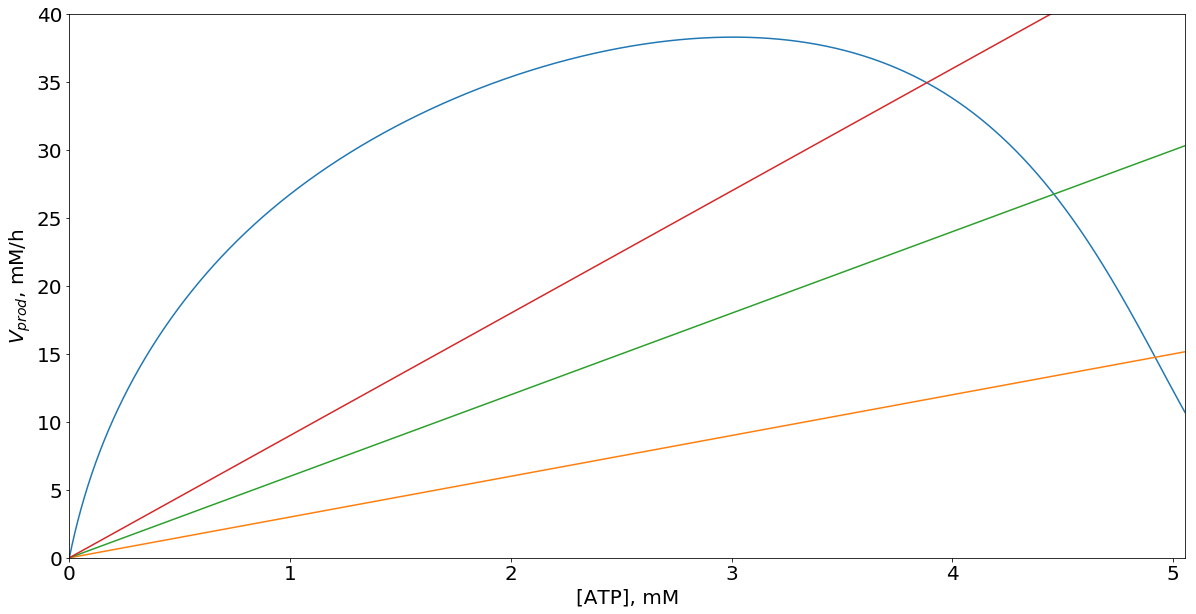

In [492]:
plt.figure(figsize = (20, 10))
f_plot(atp_p,np.array(v_production_atp_0))
plt.plot(atp_p, 3*np.array(atp_p))
plt.plot(atp_p, 6*np.array(atp_p))
plt.plot(atp_p, 9*np.array(atp_p))
# plt.plot(np.linspace(3.89, 3.89, len(np.array(v_production_atp_0))), np.array(v_production_atp_0), color='black', linestyle='dashed')
# plt.plot(np.linspace(4.45, 4.45, len(np.array(v_production_atp_0))), np.array(v_production_atp_0), color='black', linestyle='dashed')
# plt.plot(np.linspace(4.91, 4.91, len(np.array(v_production_atp_0))), np.array(v_production_atp_0), color='black', linestyle='dashed')


# plt.title('V production', size = 20)
plt.xlabel('[ATP], mM', size = 20)
plt.ylabel('$V_{prod}$, mM/h', size = 20)
plt.xlim(0, 5.055)
plt.ylim(0, 40)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

In [40]:
ep_pool = np.linspace(0, 2 * p_0 + c_0 - 6.5, 100000)

In [41]:
GP_act = [0, 50, 100, 200, 300, 400, 500, 1000, 2000, 5000]

In [42]:
#GP_act = [100, 150, 200, 250]

In [43]:
k_ak = 1
a_pgi = 360
a_ald = 76
a_gapd =690
a_pgm = 1100
a_pk = 120
a_ld = 550
a_tpi = 19522
a_pgk = 2115
a_eno = 204

# Glycolytic intermediates quantities in 1L of erythrocytes, mM
g6p = 73.1e-03
f6p = 23.9e-03
fdp = 7.49e-03
dap = 31.79e-03
gap = 14.1e-03
dpg13 = 0.734e-03
pg3 = 45.3e-03
pg2 = 10.7e-03
pep = 9.82e-03
pyr, lac = 70e-3, 1.2
po4 = 1
nad_0, nadh = 50e-3, 2e-03

#a_gp_a = 5000
a_gp_b = 5000
a_pgcm = 4200
g1p = 0.05
ACT = 100

k_ck, c_0 = 5, 30
atp, amp = 5, 0.02
# активности ГК и ФФК для мышцы, по данным Витвицкого
# усреднённые по человеку и кролику
a_hk = 60
a_pfk = 4000
v_0 = 10
#v_0 = 500

ACT_gapd, ACT_pgk, ACT_pgm, ACT_eno, ACT_pk, ACT_ld = 1, 1, 1, 1, 1, 1

In [44]:
nad = nad_0 - nadh
adp = ( atp * amp / k_ak )**0.5
p_0 = atp + adp + amp

a_atpase = v_0 / u_atpase(1, atp) 

cr, crp = equilibr_ck(k_ck, c_0, atp, adp) 
ep = 2 * atp + adp + crp
po4_0 = g1p + g6p + f6p + 2*fdp + dap + gap + 2*dpg13 + pg3 + pg2 + pep + ep + po4 

In [45]:
# [_[:0:-1] for _ in res]

In [46]:
res = [[y0] for _ in range(len(GP_act))]
atp_p_gp = [[] for _ in range(len(GP_act))]
adp_p_gp = [[] for _ in range(len(GP_act))]
amp_p_gp = [[] for _ in range(len(GP_act))]

for ep in ep_pool[3000::-1]:
    
    for ix, a_gp_a in enumerate(GP_act):
        nad = nad_0 - nadh
        po4_up = g1p + g6p + f6p + 2*fdp + dap + gap
        po4_down = 2*dpg13 + pg3 + pg2 + pep
        po4 = po4_0 - ( po4_up + po4_down + ep )
        crp = float(my_cubic_solve(coefficients(ep, c_0, p_0, k_ak, k_ck)))
        atp, adp, amp, cr = tdmc(crp, c_0, p_0, k_ak, k_ck)
        
        root = fsolve(func, res[ix][-1], full_output = True)
        
        if (root[2] == 1 and (np.isclose(func(root[0]), [0.0, 0.0, 0.0, 
                                                         0.0, 0.0, 0.0, 
                                                         0.0, 0.0, 0.0, 
                                                         0.0, 0.0])
                             ).all()
           ):
            
            res[ix].append(root[0])
            atp_p_gp[ix].append(atp)
            adp_p_gp[ix].append(adp)
            amp_p_gp[ix].append(amp)
            
res = [_[:0:-1] for _ in res]
atp_p_gp = [_[::-1] for _ in atp_p_gp]
adp_p_gp = [_[::-1] for _ in adp_p_gp]
amp_p_gp = [_[::-1] for _ in amp_p_gp]


for ep in ep_pool[3000::1]:
    
    for ix, a_gp_a in enumerate(GP_act):
        nad = nad_0 - nadh
        po4_up = g1p + g6p + f6p + 2*fdp + dap + gap
        po4_down = 2*dpg13 + pg3 + pg2 + pep
        po4 = po4_0 - ( po4_up + po4_down + ep )
        crp = float(my_cubic_solve(coefficients(ep, c_0, p_0, k_ak, k_ck)))
        atp, adp, amp, cr = tdmc(crp, c_0, p_0, k_ak, k_ck)
        
        root = fsolve(func, res[ix][-1], full_output = True)
        
        if (root[2] == 1 and (np.isclose(func(root[0]), [0.0, 0.0, 0.0, 
                                                         0.0, 0.0, 0.0, 
                                                         0.0, 0.0, 0.0, 
                                                         0.0, 0.0])
                             ).all()
           ):
            
            res[ix].append(root[0])
            atp_p_gp[ix].append(atp)
            adp_p_gp[ix].append(adp)
            amp_p_gp[ix].append(amp)

In [47]:
# res1 = [[y0] for _ in range(len(GP_act))]
# atp_p_gp1 = [[] for _ in range(len(GP_act))]
# adp_p_gp1 = [[] for _ in range(len(GP_act))]
# amp_p_gp1 = [[] for _ in range(len(GP_act))]

# for ep in np.linspace(30, 2 * p_0 + c_0 - 6.5, 50000)[::-1]:
    
#     for ix, a_gp_a in enumerate(GP_act):
#         nad = nad_0 - nadh
#         po4_up = g1p + g6p + f6p + 2*fdp + dap + gap
#         po4_down = 2*dpg13 + pg3 + pg2 + pep
#         po4 = po4_0 - ( po4_up + po4_down + ep )
#         crp = float(my_cubic_solve(coefficients(ep, c_0, p_0, k_ak, k_ck)))
#         atp, adp, amp, cr = tdmc(crp, c_0, p_0, k_ak, k_ck)
        
#         root = fsolve(func, res[ix][-1], full_output = True)
        
#         if (root[2] == 1 and (np.isclose(func(root[0]), [0.0, 0.0, 0.0, 
#                                                          0.0, 0.0, 0.0, 
#                                                          0.0, 0.0, 0.0, 
#                                                          0.0, 0.0])
#                              ).all()):
            
#             res1[ix].append(root[0])
#             atp_p_gp1[ix].append(atp)
#             adp_p_gp1[ix].append(adp)
#             amp_p_gp1[ix].append(amp)

res[act][atp][met]

In [48]:
len(GP_act)

10

In [49]:
f6p = [[i[0] for i in res[j][0:]] for j in range(len(GP_act))]
fdp = [[i[1] for i in res[j][0:]] for j in range(len(GP_act))]
dap = [[i[2] for i in res[j][0:]] for j in range(len(GP_act))]
gap = [[i[3] for i in res[j][0:]] for j in range(len(GP_act))]
dpg13 = [[i[4] for i in res[j][0:]] for j in range(len(GP_act))]
pg3 = [[i[5] for i in res[j][0:]] for j in range(len(GP_act))]
pg2 = [[i[6] for i in res[j][0:]] for j in range(len(GP_act))]
pep = [[i[7] for i in res[j][0:]] for j in range(len(GP_act))]
nadh = [[i[8] for i in res[j][0:]] for j in range(len(GP_act))]
g6p = [[i[9] for i in res[j][0:]] for j in range(len(GP_act))]
g1p = [[i[10] for i in res[j][0:]] for j in range(len(GP_act))]

In [50]:
# f6p1 = [[i[0] for i in res1[j][0:]] for j in range(len(GP_act))]
# fdp1 = [[i[1] for i in res1[j][0:]] for j in range(len(GP_act))]
# dap1 = [[i[2] for i in res1[j][0:]] for j in range(len(GP_act))]
# gap1 = [[i[3] for i in res1[j][0:]] for j in range(len(GP_act))]
# dpg131 = [[i[4] for i in res1[j][0:]] for j in range(len(GP_act))]
# pg31 = [[i[5] for i in res1[j][0:]] for j in range(len(GP_act))]
# pg21 = [[i[6] for i in res1[j][0:]] for j in range(len(GP_act))]
# pep1 = [[i[7] for i in res1[j][0:]] for j in range(len(GP_act))]
# nadh1 = [[i[8] for i in res1[j][0:]] for j in range(len(GP_act))]
# g6p1 = [[i[9] for i in res1[j][0:]] for j in range(len(GP_act))]
# g1p1 = [[i[10] for i in res1[j][0:]] for j in range(len(GP_act))]

In [51]:
# f6p_1 = [[0 for i in range(len(res1[j][1:]) + len(res[j][1:]))] for j in range(len(GP_act))] 
# fdp_1 = [[0 for i in range(len(res1[j][1:]) + len(res[j][1:]))] for j in range(len(GP_act))] 
# dap_1 = [[0 for i in range(len(res1[j][1:]) + len(res[j][1:]))] for j in range(len(GP_act))] 
# gap_1 = [[0 for i in range(len(res1[j][1:]) + len(res[j][1:]))] for j in range(len(GP_act))] 
# dpg13_1 = [[0 for i in range(len(res1[j][1:]) + len(res[j][1:]))] for j in range(len(GP_act))] 
# pg3_1 = [[0 for i in range(len(res1[j][1:]) + len(res[j][1:]))] for j in range(len(GP_act))] 
# pg2_1 = [[0 for i in range(len(res1[j][1:]) + len(res[j][1:]))] for j in range(len(GP_act))] 
# pep_1 = [[0 for i in range(len(res1[j][1:]) + len(res[j][1:]))] for j in range(len(GP_act))] 
# nadh_1 = [[0 for i in range(len(res1[j][1:]) + len(res[j][1:]))] for j in range(len(GP_act))] 
# g6p_1 = [[0 for i in range(len(res1[j][1:]) + len(res[j][1:]))] for j in range(len(GP_act))] 
# g1p_1 = [[0 for i in range(len(res1[j][1:]) + len(res[j][1:]))] for j in range(len(GP_act))] 

In [52]:
# for i in range(len(GP_act)):
#     f6p_1[i] = f6p[i] + f6p1[i]
#     fdp_1[i] = fdp[i] + fdp1[i]
#     dap_1[i] = dap[i] + dap1[i]
#     gap_1[i] = gap[i] + gap1[i]
#     dpg13_1[i] = dpg13[i] + dpg131[i]
#     pg3_1[i] = pg3[i] + pg31[i]
#     pg2_1[i] = pg2[i] + pg21[i]
#     pep_1[i] = pep[i] + pep1[i]
#     nadh_1[i] = nadh[i] + nadh1[i]
#     g6p_1[i] = g6p[i] + g6p1[i]
#     g1p_1[i] = g1p[i] + g1p1[i]

In [53]:
# atp_p_gp_1 = [[0 for i in range(len(res1[j][1:]) + len(res[j][1:]))] for j in range(len(GP_act))] 
# adp_p_gp_1 = [[0 for i in range(len(res1[j][1:]) + len(res[j][1:]))] for j in range(len(GP_act))] 
# amp_p_gp_1 = [[0 for i in range(len(res1[j][1:]) + len(res[j][1:]))] for j in range(len(GP_act))] 

In [54]:
# for i in range(len(GP_act)):
#     atp_p_gp_1[i] = atp_p_gp[i] + atp_p_gp1[i]
#     adp_p_gp_1[i] = adp_p_gp[i] + adp_p_gp1[i]
#     amp_p_gp_1[i] = amp_p_gp[i] + amp_p_gp1[i]

In [55]:
# Creates a list containing 5 lists, each of 8 items, all set to 0
#w, h = 8, 5
#Matrix = [[0 for x in range(w)] for y in range(h)] 

In [56]:
# v_hk_atp_gp = [[] for _ in range(len(GP_act))]
# v_pfk_atp_gp = [[] for _ in range(len(GP_act))]
# v_pgk_atp_gp = [[] for _ in range(len(GP_act))]
# v_pk_atp_gp = [[] for _ in range(len(GP_act))]
# #v_production_atp_gp = [[] for _ in range(len(atp_p))]
# for i, a_gp_a in enumerate(GP_act):
#     for ix, atp in enumerate(atp_p_gp_1[i]):
#         v_hk_atp_gp[i].append(u_hk(a_hk, atp, g6p_1[i][ix]))
#         v_pfk_atp_gp[i].append(u_pfk(a_pfk, atp, amp_p_gp_1[i][ix], f6p_1[i][ix]))
#         v_pgk_atp_gp[i].append(u_pgk(a_pgk * ACT, dpg13_1[i][ix], adp_p_gp_1[i][ix], pg3_1[i][ix], atp))
#         v_pk_atp_gp[i].append(u_pk(a_pk * ACT, pep_1[i][ix], adp_p_gp_1[i][ix], atp))
#         #v_production_atp_gp[ix].append(-np.array(v_hk_atp_gp)[ix, i] - np.array(v_pfk_atp_gp)[ix, i] + np.array(v_pgk_atp_gp)[ix, i] + np.array(v_pk_atp_gp)[ix, i])

Без доп точек

In [57]:
v_hk_atp_gp_n = [[] for _ in range(len(GP_act))]
v_pfk_atp_gp_n = [[] for _ in range(len(GP_act))]
v_pgk_atp_gp_n = [[] for _ in range(len(GP_act))]
v_pk_atp_gp_n = [[] for _ in range(len(GP_act))]
#v_production_atp_gp = [[] for _ in range(len(atp_p))]
for i, a_gp_a in enumerate(GP_act):
    for ix, atp in enumerate(atp_p_gp[i]):
        v_hk_atp_gp_n[i].append(u_hk(a_hk, atp, g6p[i][ix]))
        v_pfk_atp_gp_n[i].append(u_pfk(a_pfk, atp, amp_p_gp[i][ix], f6p[i][ix]))
        v_pgk_atp_gp_n[i].append(u_pgk(a_pgk * ACT, dpg13[i][ix], adp_p_gp[i][ix], pg3[i][ix], atp))
        v_pk_atp_gp_n[i].append(u_pk(a_pk * ACT, pep[i][ix], adp_p_gp[i][ix], atp))
        #v_production_atp_gp[ix].append(-np.array(v_hk_atp_gp)[ix, i] - np.array(v_pfk_atp_gp)[ix, i] + np.array(v_pgk_atp_gp)[ix, i] + np.array(v_pk_atp_gp)[ix, i])

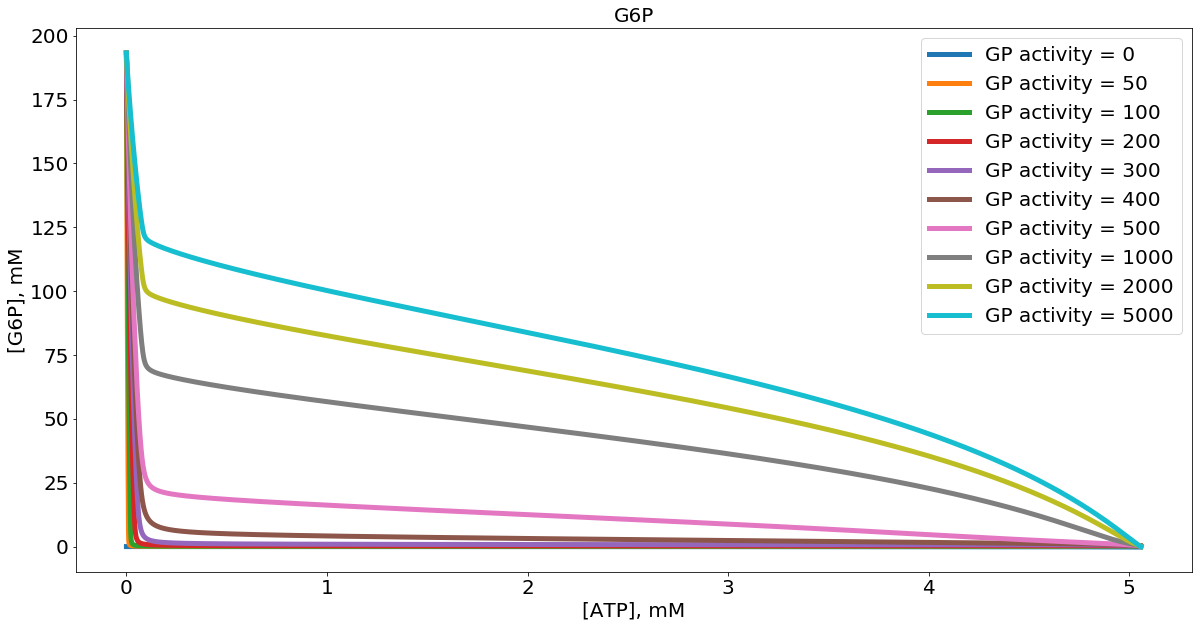

In [58]:
plt.figure(figsize = (20, 10))
#f_plot(atp_p,np.array(v_hk_atp_0))
plt.plot(atp_p_gp[0],g6p[0], linewidth=5)
plt.plot(atp_p_gp[1],g6p[1], linewidth=5)
plt.plot(atp_p_gp[2],g6p[2], linewidth=5)
plt.plot(atp_p_gp[3],g6p[3], linewidth=5)
plt.plot(atp_p_gp[4],g6p[4], linewidth=5)
plt.plot(atp_p_gp[5],g6p[5], linewidth=5)
plt.plot(atp_p_gp[6],g6p[6], linewidth=5)
plt.plot(atp_p_gp[7],g6p[7], linewidth=5)
plt.plot(atp_p_gp[8],g6p[8], linewidth=5)
plt.plot(atp_p_gp[9],g6p[9], linewidth=5)
#plt.plot(atp_p,np.array(v_pfk_atp), color = 'green')
plt.title('G6P', size = 20)
plt.xlabel('[ATP], mM', size = 20)
plt.ylabel('[G6P], mM', size = 20)
plt.legend([f'GP activity = {GP_act[0]}',\
            f'GP activity = {GP_act[1]}',\
            f'GP activity = {GP_act[2]}', \
            f'GP activity = {GP_act[3]}', \
            f'GP activity = {GP_act[4]}', \
            f'GP activity = {GP_act[5]}', \
            f'GP activity = {GP_act[6]}', \
            f'GP activity = {GP_act[7]}', \
            f'GP activity = {GP_act[8]}', \
            f'GP activity = {GP_act[9]}'
           ], fontsize = 20)
#plt.xlim(0, 5.055)
#plt.ylim(0, 30)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

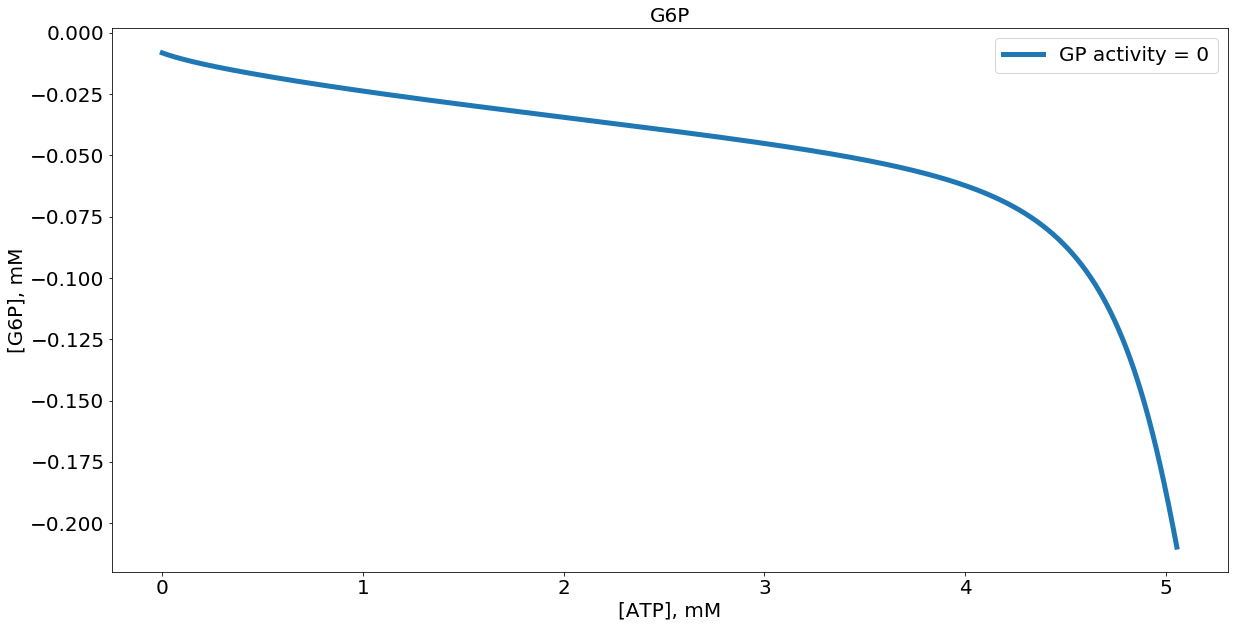

In [83]:
plt.figure(figsize = (20, 10))
#f_plot(atp_p,np.array(v_hk_atp_0))
plt.plot(atp_p_gp[0],g6p[0], linewidth=5)
#plt.plot(atp_p,np.array(v_pfk_atp), color = 'green')
plt.title('G6P', size = 20)
plt.xlabel('[ATP], mM', size = 20)
plt.ylabel('[G6P], mM', size = 20)
plt.legend([f'GP activity = {GP_act[0]}'
           ], fontsize = 20)
#plt.xlim(0, 5.055)
#plt.ylim(0, 30)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

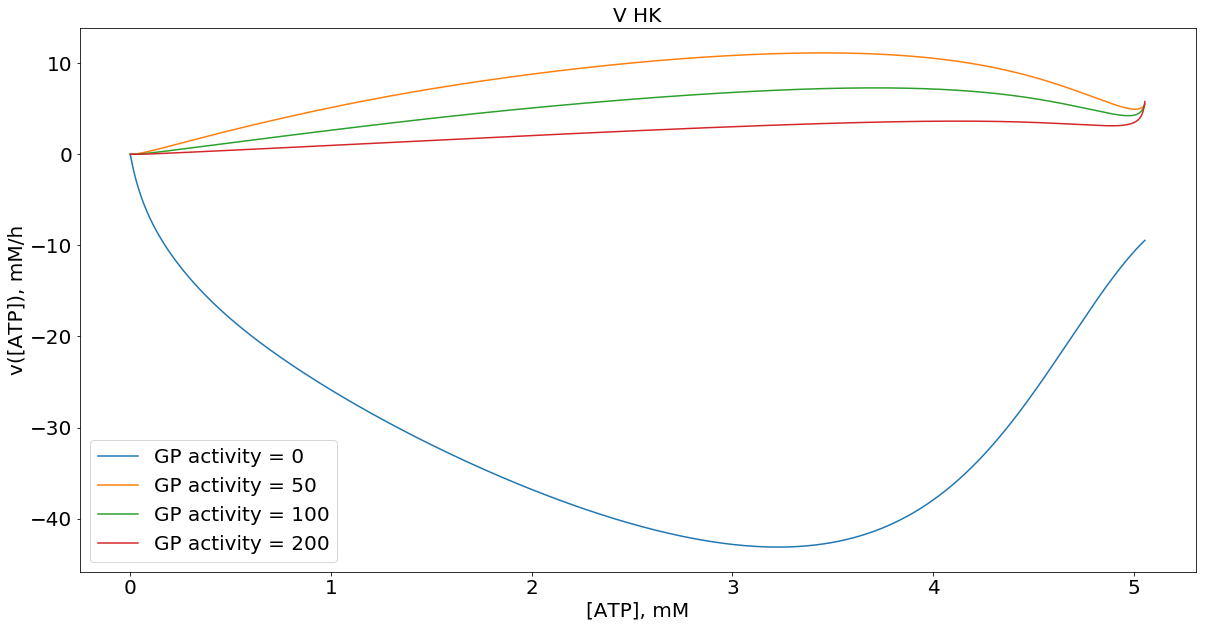

In [84]:
plt.figure(figsize = (20, 10))
#f_plot(atp_p,np.array(v_hk_atp_0))
f_plot(atp_p_gp[0],v_hk_atp_gp_n[0])
f_plot(atp_p_gp[1],v_hk_atp_gp_n[1])
f_plot(atp_p_gp[2],v_hk_atp_gp_n[2])
f_plot(atp_p_gp[3],v_hk_atp_gp_n[3])
#f_plot(atp_p_gp[4],v_hk_atp_gp_n[4])
#f_plot(atp_p_gp[5],v_hk_atp_gp_n[5])
#f_plot(atp_p_gp[6],v_hk_atp_gp_n[6])
#f_plot(atp_p_gp[7],v_hk_atp_gp_n[7])
#plt.plot(atp_p,np.array(v_pfk_atp), color = 'green')
plt.title('V HK', size = 20)
plt.xlabel('[ATP], mM', size = 20)
plt.ylabel('v([ATP]), mM/h', size = 20)
plt.legend([f'GP activity = {GP_act[0]}',\
            f'GP activity = {GP_act[1]}',\
            f'GP activity = {GP_act[2]}', \
            f'GP activity = {GP_act[3]}', \
            #f'GP activity = {GP_act[4]}', \
            #f'GP activity = {GP_act[5]}', \
            #f'GP activity = {GP_act[6]}', \
            #f'GP activity = {GP_act[7]}'
           ], fontsize = 20)
#plt.xlim(0, 5.055)
#plt.ylim(0, 30)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

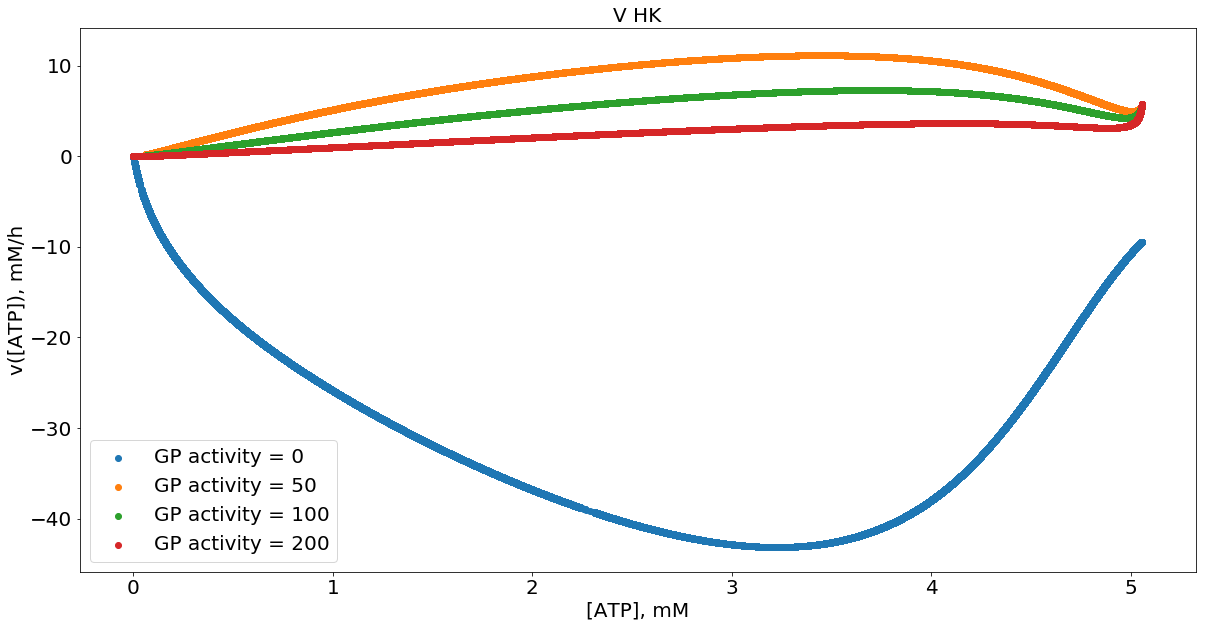

In [60]:
plt.figure(figsize = (20, 10))
#f_plot(atp_p,np.array(v_hk_atp_0))
plt.scatter(atp_p_gp[0],v_hk_atp_gp_n[0])
plt.scatter(atp_p_gp[1],v_hk_atp_gp_n[1])
plt.scatter(atp_p_gp[2],v_hk_atp_gp_n[2])
plt.scatter(atp_p_gp[3],v_hk_atp_gp_n[3])
#f_plot(atp_p_gp[4],v_hk_atp_gp_n[4])
#f_plot(atp_p_gp[5],v_hk_atp_gp_n[5])
#f_plot(atp_p_gp[6],v_hk_atp_gp_n[6])
#f_plot(atp_p_gp[7],v_hk_atp_gp_n[7])
#plt.plot(atp_p,np.array(v_pfk_atp), color = 'green')
plt.title('V HK', size = 20)
plt.xlabel('[ATP], mM', size = 20)
plt.ylabel('v([ATP]), mM/h', size = 20)
plt.legend([f'GP activity = {GP_act[0]}',\
            f'GP activity = {GP_act[1]}',\
            f'GP activity = {GP_act[2]}', \
            f'GP activity = {GP_act[3]}', \
            #f'GP activity = {GP_act[4]}', \
            #f'GP activity = {GP_act[5]}', \
            #f'GP activity = {GP_act[6]}', \
            #f'GP activity = {GP_act[7]}'
           ], fontsize = 20)
#plt.xlim(0, 5.055)
#plt.ylim(0, 30)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

In [61]:
# plt.figure(figsize = (20, 10))
# plt.scatter(atp_p_gp_1[0],v_hk_atp_gp[0])
# plt.scatter(atp_p_gp_1[1],v_hk_atp_gp[1])
# plt.scatter(atp_p_gp_1[2],v_hk_atp_gp[2])
# plt.scatter(atp_p_gp_1[3],v_hk_atp_gp[3])
# plt.scatter(atp_p_gp_1[4],v_hk_atp_gp[4])
# plt.scatter(atp_p_gp_1[5],v_hk_atp_gp[5])
# plt.scatter(atp_p_gp_1[6],v_hk_atp_gp[6])
# plt.title('V HK', size = 20)
# plt.xlabel('[ATP]', size = 20)
# plt.ylabel('v([ATP])', size = 20)
# plt.legend([f'GP activity = {GP_act[0]}',\
#             f'GP activity = {GP_act[1]}',\
#             f'GP activity = {GP_act[2]}', \
#             f'GP activity = {GP_act[3]}', \
#             f'GP activity = {GP_act[4]}',\
#             f'GP activity = {GP_act[5]}',\
#             f'GP activity = {GP_act[6]}'], fontsize = 20)
# #plt.xlim(0, 5.1)
# #plt.ylim(0, 30)
# plt.xticks(size = 20)
# plt.yticks(size = 20)
# plt.show()

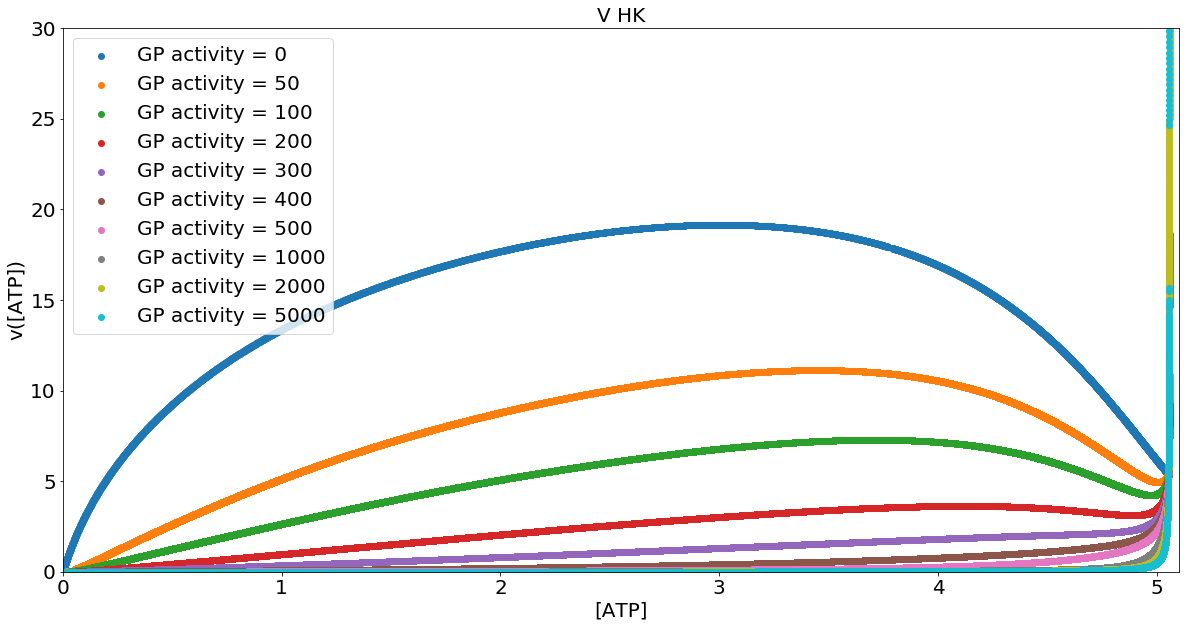

In [62]:
plt.figure(figsize = (20, 10))
plt.scatter(atp_p,np.array(v_hk_atp_0))
plt.scatter(atp_p_gp[1],v_hk_atp_gp_n[1])
plt.scatter(atp_p_gp[2],v_hk_atp_gp_n[2])
plt.scatter(atp_p_gp[3],v_hk_atp_gp_n[3])
plt.scatter(atp_p_gp[4],v_hk_atp_gp_n[4])
plt.scatter(atp_p_gp[5],v_hk_atp_gp_n[5])
plt.scatter(atp_p_gp[6],v_hk_atp_gp_n[6])
plt.scatter(atp_p_gp[7],v_hk_atp_gp_n[7])
plt.scatter(atp_p_gp[8],v_hk_atp_gp_n[8])
plt.scatter(atp_p_gp[9],v_hk_atp_gp_n[9])
plt.title('V HK', size = 20)
plt.xlabel('[ATP]', size = 20)
plt.ylabel('v([ATP])', size = 20)
plt.legend([f'GP activity = {GP_act[0]}',\
            f'GP activity = {GP_act[1]}',\
            f'GP activity = {GP_act[2]}', \
            f'GP activity = {GP_act[3]}', \
            f'GP activity = {GP_act[4]}',\
            f'GP activity = {GP_act[5]}',\
            f'GP activity = {GP_act[6]}',\
            f'GP activity = {GP_act[7]}',\
            f'GP activity = {GP_act[8]}',\
            f'GP activity = {GP_act[9]}'], fontsize = 20)
plt.xlim(0, 5.1)
plt.ylim(0, 30)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

/Users/svetlanasudarkina/anaconda3/lib/python3.7/site-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "outside lower center". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


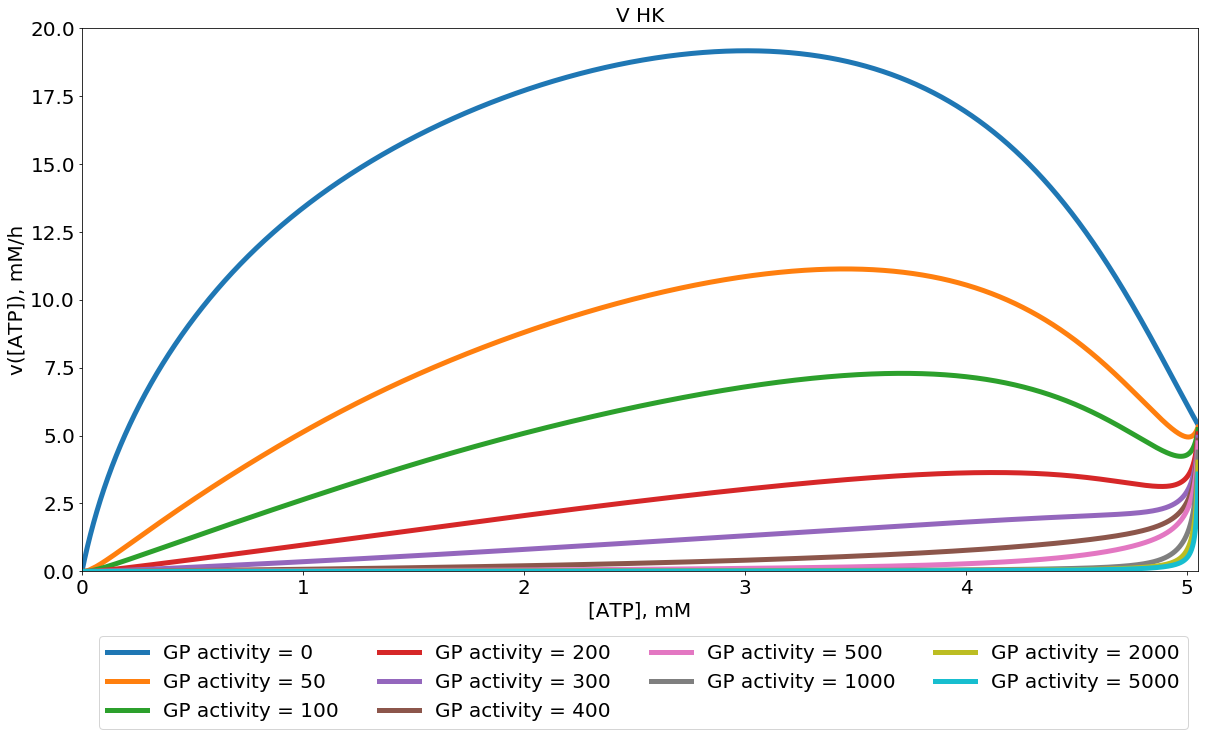

In [63]:
plt.figure(figsize = (20, 10))
plt.plot(atp_p,np.array(v_hk_atp_0), linewidth=5)
plt.plot(atp_p_gp[1],v_hk_atp_gp_n[1], linewidth=5)
plt.plot(atp_p_gp[2],v_hk_atp_gp_n[2], linewidth=5)
plt.plot(atp_p_gp[3],v_hk_atp_gp_n[3], linewidth=5)
plt.plot(atp_p_gp[4],v_hk_atp_gp_n[4], linewidth=5)
plt.plot(atp_p_gp[5],v_hk_atp_gp_n[5], linewidth=5)
plt.plot(atp_p_gp[6],v_hk_atp_gp_n[6], linewidth=5)
plt.plot(atp_p_gp[7],v_hk_atp_gp_n[7], linewidth=5)
plt.plot(atp_p_gp[8],v_hk_atp_gp_n[8], linewidth=5)
plt.plot(atp_p_gp[9],v_hk_atp_gp_n[9], linewidth=5)
plt.title('V HK', size = 20)
plt.xlabel('[ATP], mM', size = 20)
plt.ylabel('v([ATP]), mM/h', size = 20)
plt.legend([f'GP activity = {GP_act[0]}',\
            f'GP activity = {GP_act[1]}',\
            f'GP activity = {GP_act[2]}', \
            f'GP activity = {GP_act[3]}', \
            f'GP activity = {GP_act[4]}',\
            f'GP activity = {GP_act[5]}',\
            f'GP activity = {GP_act[6]}',\
            f'GP activity = {GP_act[7]}',\
            f'GP activity = {GP_act[8]}',\
            f'GP activity = {GP_act[9]}'], fontsize = 20,
           loc='outside lower center', 
    bbox_to_anchor=(1, -0.1),
    ncol=4, )
          
plt.xlim(0, 5.05)
plt.ylim(0, 20)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

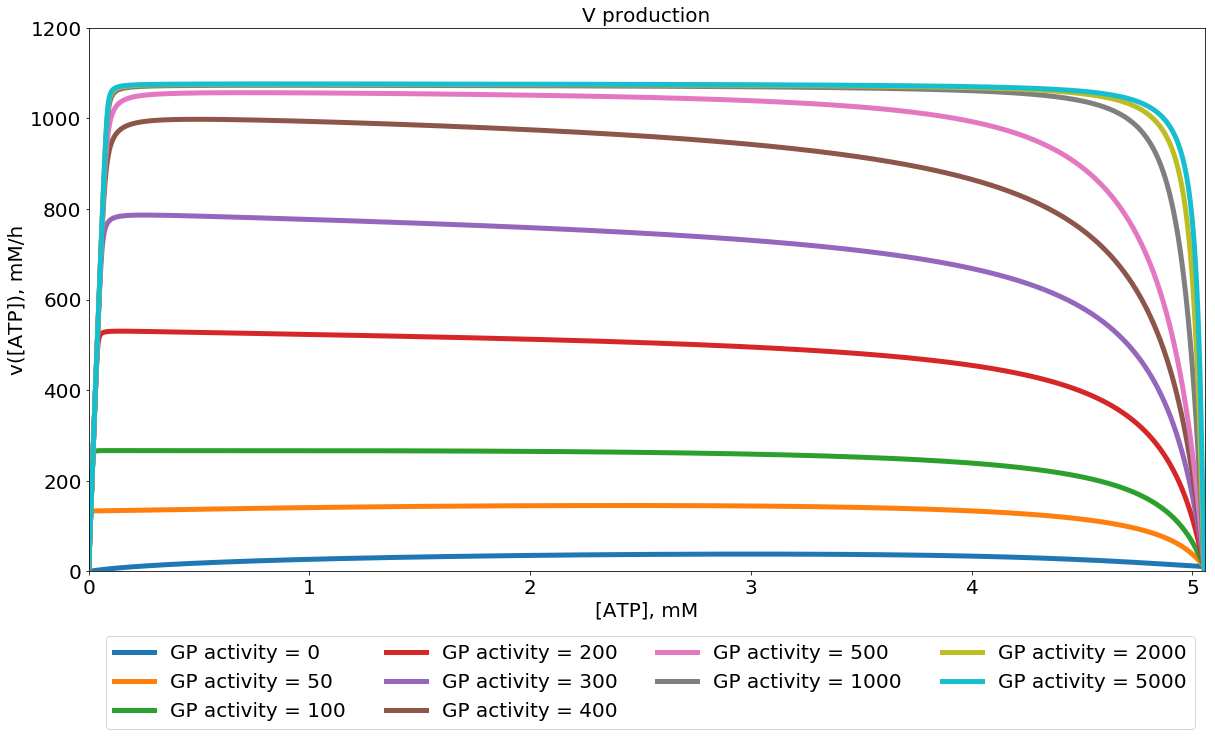

In [67]:
plt.figure(figsize = (20, 10))
plt.plot(atp_p,np.array(v_production_atp_0), linewidth=5)
plt.plot(atp_p_gp[1],v_production_atp_gp[1],linewidth=5)
plt.plot(atp_p_gp[2],v_production_atp_gp[2],linewidth=5)
plt.plot(atp_p_gp[3],v_production_atp_gp[3],linewidth=5)
plt.plot(atp_p_gp[4],v_production_atp_gp[4],linewidth=5)
plt.plot(atp_p_gp[5],v_production_atp_gp[5],linewidth=5)
plt.plot(atp_p_gp[6],v_production_atp_gp[6],linewidth=5)
plt.plot(atp_p_gp[7],v_production_atp_gp[7],linewidth=5)
plt.plot(atp_p_gp[8],v_production_atp_gp[8],linewidth=5)
plt.plot(atp_p_gp[9],v_production_atp_gp[9],linewidth=5)


plt.title('V production', size = 20)
plt.xlabel('[ATP], mM', size = 20)
plt.ylabel('v([ATP]), mM/h', size = 20)
plt.legend([f'GP activity = {GP_act[0]}',\
            f'GP activity = {GP_act[1]}',\
            f'GP activity = {GP_act[2]}', \
            f'GP activity = {GP_act[3]}',\
            f'GP activity = {GP_act[4]}',\
            f'GP activity = {GP_act[5]}',\
            f'GP activity = {GP_act[6]}',\
            f'GP activity = {GP_act[7]}',\
            f'GP activity = {GP_act[8]}',\
            f'GP activity = {GP_act[9]}'], fontsize = 20,
           loc='outside lower center', 
    bbox_to_anchor=(1, -0.1),
    ncol=4, )
plt.xlim(0, 5.055)
plt.ylim(0, 1200)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

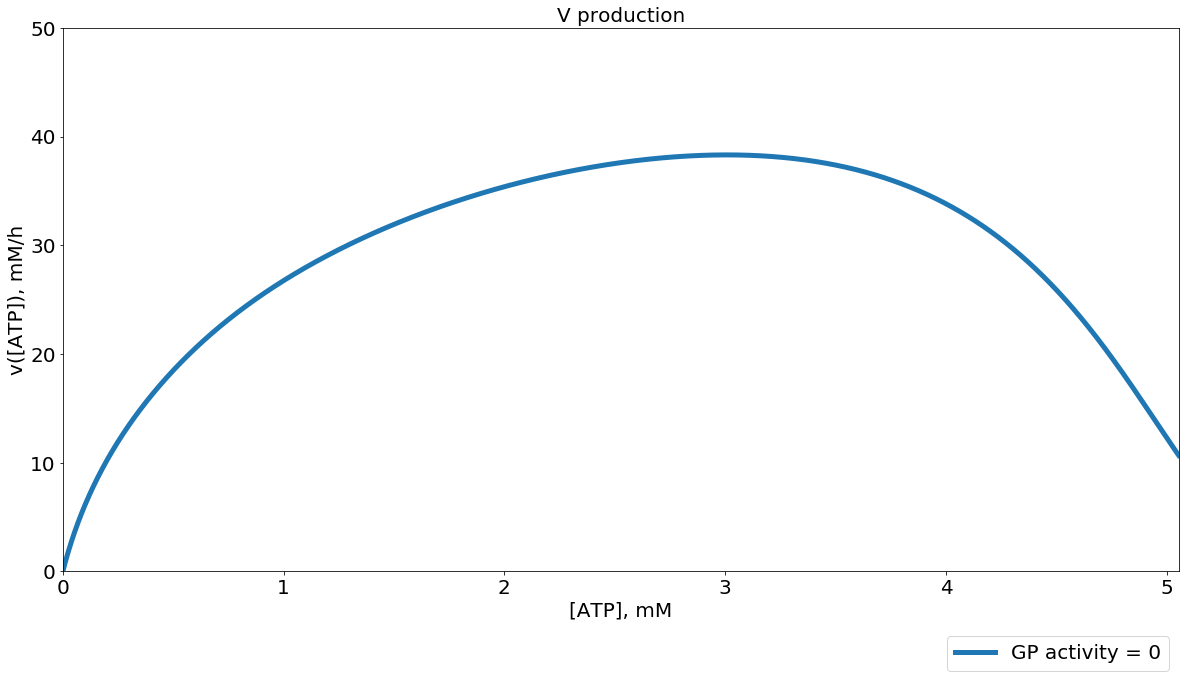

In [69]:
plt.figure(figsize = (20, 10))
plt.plot(atp_p,np.array(v_production_atp_0), linewidth=5)


plt.title('V production', size = 20)
plt.xlabel('[ATP], mM', size = 20)
plt.ylabel('v([ATP]), mM/h', size = 20)
plt.legend([f'GP activity = {GP_act[0]}'], fontsize = 20,
           loc='outside lower center', 
    bbox_to_anchor=(1, -0.1),
    ncol=4, )
plt.xlim(0, 5.055)
plt.ylim(0, 50)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

In [70]:
len(atp_p)

4952

In [71]:
atp_p[4457] #-- 90% pool

4.841629573833256

In [75]:
len(f6p[0])

97850

In [ ]:
plt.figure(figsize = (20, 10))
f_plot(atp_p,np.array(v_pfk_atp_0))
f_plot(atp_p_gp[1],v_pfk_atp_gp_n[1])
f_plot(atp_p_gp[2],v_pfk_atp_gp_n[2])
f_plot(atp_p_gp[4],v_pfk_atp_gp_n[4])
f_plot(atp_p_gp[5],v_pfk_atp_gp_n[5])
f_plot(atp_p_gp[6],v_pfk_atp_gp_n[6])
f_plot(atp_p_gp[7],v_pfk_atp_gp_n[7])
f_plot(atp_p_gp[8],v_pfk_atp_gp_n[8])
f_plot(atp_p_gp[9],v_pfk_atp_gp_n[9])
#plt.plot(atp_p,np.array(v_pfk_atp), color = 'green')
plt.title('V PFK', size = 20)
plt.xlabel('[ATP]', size = 20)
plt.ylabel('v([ATP])', size = 20)
plt.legend([#f'GP activity = {GP_act[0]}',\
            f'GP activity = {GP_act[1]}',\
            f'GP activity = {GP_act[2]}', \
            f'GP activity = {GP_act[4]}',\
            f'GP activity = {GP_act[5]}',\
            f'GP activity = {GP_act[6]}',\
            f'GP activity = {GP_act[7]}',\
            f'GP activity = {GP_act[8]}',\
            f'GP activity = {GP_act[9]}'], fontsize = 20)
#plt.xlim(0, 5.055)
#plt.ylim(0, 500)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

In [ ]:
# plt.figure(figsize = (20, 10))
# plt.scatter(atp_p_gp_1[0],v_pfk_atp_gp[0])
# plt.scatter(atp_p_gp_1[1],v_pfk_atp_gp[1])
# plt.scatter(atp_p_gp_1[2],v_pfk_atp_gp[2])
# plt.scatter(atp_p_gp_1[3],v_pfk_atp_gp[3])
# plt.scatter(atp_p_gp_1[4],v_pfk_atp_gp[4])
# plt.scatter(atp_p_gp_1[5],v_pfk_atp_gp[5])
# plt.scatter(atp_p_gp_1[6],v_pfk_atp_gp[6])
# #plt.plot(atp_p,np.array(v_pfk_atp), color = 'green')
# plt.title('V PFK', size = 20)
# plt.xlabel('[ATP]', size = 20)
# plt.ylabel('v([ATP])', size = 20)
# plt.legend([f'GP activity = {GP_act[0]}',\
#             f'GP activity = {GP_act[1]}',\
#             f'GP activity = {GP_act[2]}', \
#             f'GP activity = {GP_act[3]}',\
#             f'GP activity = {GP_act[4]}',\
#             f'GP activity = {GP_act[5]}',\
#             f'GP activity = {GP_act[6]}'], fontsize = 20)
# #plt.xlim(0, 5.055)
# #plt.ylim(0, 500)
# plt.xticks(size = 20)
# plt.yticks(size = 20)
# plt.show()

In [ ]:
plt.figure(figsize = (20, 10))
plt.scatter(atp_p,np.array(v_pfk_atp_0))
plt.scatter(atp_p_gp[1],v_pfk_atp_gp_n[1])
plt.scatter(atp_p_gp[2],v_pfk_atp_gp_n[2])
plt.scatter(atp_p_gp[3],v_pfk_atp_gp_n[3])
plt.scatter(atp_p_gp[4],v_pfk_atp_gp_n[4])
plt.scatter(atp_p_gp[5],v_pfk_atp_gp_n[5])
plt.scatter(atp_p_gp[6],v_pfk_atp_gp_n[6])
plt.scatter(atp_p_gp[7],v_pfk_atp_gp_n[7])
plt.scatter(atp_p_gp[8],v_pfk_atp_gp_n[8])
plt.scatter(atp_p_gp[9],v_pfk_atp_gp_n[9])
#plt.plot(atp_p,np.array(v_pfk_atp), color = 'green')
plt.title('V PFK', size = 20)
plt.xlabel('[ATP], mM', size = 20)
plt.ylabel('v([ATP]), mM/h', size = 20)
plt.legend([f'GP activity = {GP_act[0]}',\
            f'GP activity = {GP_act[1]}',\
            f'GP activity = {GP_act[2]}', \
            f'GP activity = {GP_act[3]}',\
            f'GP activity = {GP_act[4]}',\
            f'GP activity = {GP_act[5]}',\
            f'GP activity = {GP_act[6]}',\
            f'GP activity = {GP_act[7]}',\
            f'GP activity = {GP_act[8]}',\
            f'GP activity = {GP_act[9]}'], fontsize = 20)
#plt.xlim(0, 5.055)
#plt.ylim(0, 500)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

In [ ]:
plt.figure(figsize = (20, 10))
f_plot(atp_p,np.array(v_pfk_atp_0))
f_plot(atp_p_gp[1],v_pfk_atp_gp_n[1])
f_plot(atp_p_gp[2],v_pfk_atp_gp_n[2])
f_plot(atp_p_gp[3],v_pfk_atp_gp_n[3])
f_plot(atp_p_gp[4],v_pfk_atp_gp_n[4])
f_plot(atp_p_gp[5],v_pfk_atp_gp_n[5])
f_plot(atp_p_gp[6],v_pfk_atp_gp_n[6])
f_plot(atp_p_gp[7],v_pfk_atp_gp_n[7])
f_plot(atp_p_gp[8],v_pfk_atp_gp_n[8])
f_plot(atp_p_gp[9],v_pfk_atp_gp_n[9])
#plt.plot(atp_p,np.array(v_pfk_atp), color = 'green')
plt.title('V PFK', size = 20)
plt.xlabel('[ATP], mM', size = 20)
plt.ylabel('v([ATP]), mM/h', size = 20)
plt.legend([f'GP activity = {GP_act[0]}',\
            f'GP activity = {GP_act[1]}',\
            f'GP activity = {GP_act[2]}', \
            f'GP activity = {GP_act[3]}',\
            f'GP activity = {GP_act[4]}',\
            f'GP activity = {GP_act[5]}',\
            f'GP activity = {GP_act[6]}',\
            f'GP activity = {GP_act[7]}',\
            f'GP activity = {GP_act[8]}',\
            f'GP activity = {GP_act[9]}'], fontsize = 20)
#plt.xlim(0, 5.055)
#plt.ylim(0, 500)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

In [ ]:
plt.figure(figsize = (20, 10))
plt.scatter(atp_p,np.array(v_pfk_atp_0))
plt.scatter(atp_p_gp[1],v_pgk_atp_gp_n[1])
plt.scatter(atp_p_gp[2],v_pgk_atp_gp_n[2])
plt.scatter(atp_p_gp[3],v_pgk_atp_gp_n[3])
plt.scatter(atp_p_gp[4],v_pgk_atp_gp_n[4])
plt.scatter(atp_p_gp[5],v_pgk_atp_gp_n[5])
plt.scatter(atp_p_gp[6],v_pgk_atp_gp_n[6])
plt.scatter(atp_p_gp[7],v_pgk_atp_gp_n[7])
plt.scatter(atp_p_gp[8],v_pgk_atp_gp_n[8])
plt.scatter(atp_p_gp[9],v_pgk_atp_gp_n[9])
#plt.plot(atp_p,np.array(v_pfk_atp), color = 'green')
plt.title('V PGK', size = 20)
plt.xlabel('[ATP], mM', size = 20)
plt.ylabel('v([ATP]), mM/h', size = 20)
plt.legend([f'GP activity = {GP_act[0]}',\
            f'GP activity = {GP_act[1]}',\
            f'GP activity = {GP_act[2]}', \
            f'GP activity = {GP_act[3]}',\
            f'GP activity = {GP_act[4]}',\
            f'GP activity = {GP_act[5]}',\
            f'GP activity = {GP_act[6]}',\
            f'GP activity = {GP_act[7]}',\
            f'GP activity = {GP_act[8]}',\
            f'GP activity = {GP_act[9]}'], fontsize = 20)
#plt.xlim(0, 5.055)
#plt.ylim(0, 500)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

In [ ]:
plt.figure(figsize = (20, 10))
f_plot(atp_p,np.array(v_pgk_atp_0))
f_plot(atp_p_gp[1],v_pgk_atp_gp_n[1])
f_plot(atp_p_gp[2],v_pgk_atp_gp_n[2])
f_plot(atp_p_gp[3],v_pgk_atp_gp_n[3])
f_plot(atp_p_gp[4],v_pgk_atp_gp_n[4])
f_plot(atp_p_gp[5],v_pgk_atp_gp_n[5])
f_plot(atp_p_gp[6],v_pgk_atp_gp_n[6])
f_plot(atp_p_gp[7],v_pgk_atp_gp_n[7])
f_plot(atp_p_gp[8],v_pgk_atp_gp_n[8])
f_plot(atp_p_gp[9],v_pgk_atp_gp_n[9])
#plt.plot(atp_p,np.array(v_pfk_atp), color = 'green')
plt.title('V PGK', size = 20)
plt.xlabel('[ATP], mM', size = 20)
plt.ylabel('v([ATP]), mM/h', size = 20)
plt.legend([f'GP activity = {GP_act[0]}',\
            f'GP activity = {GP_act[1]}',\
            f'GP activity = {GP_act[2]}', \
            f'GP activity = {GP_act[3]}',\
            f'GP activity = {GP_act[4]}',\
            f'GP activity = {GP_act[5]}',\
            f'GP activity = {GP_act[6]}',\
            f'GP activity = {GP_act[7]}',\
            f'GP activity = {GP_act[8]}',\
            f'GP activity = {GP_act[9]}'], fontsize = 20)
#plt.xlim(0, 5.055)
#plt.ylim(0, 1000)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

In [ ]:
plt.figure(figsize = (20, 10))
plt.scatter(atp_p,np.array(v_pk_atp_0))
plt.scatter(atp_p_gp[1],v_pk_atp_gp_n[1])
plt.scatter(atp_p_gp[2],v_pk_atp_gp_n[2])
plt.scatter(atp_p_gp[3],v_pk_atp_gp_n[3])
plt.scatter(atp_p_gp[4],v_pk_atp_gp_n[4])
plt.scatter(atp_p_gp[5],v_pk_atp_gp_n[5])
plt.scatter(atp_p_gp[6],v_pk_atp_gp_n[6])
plt.scatter(atp_p_gp[7],v_pk_atp_gp_n[7])
plt.scatter(atp_p_gp[8],v_pk_atp_gp_n[8])
plt.scatter(atp_p_gp[9],v_pk_atp_gp_n[9])
#plt.plot(atp_p,np.array(v_pk_atp), color = 'green')
plt.title('V PK', size = 20)
plt.xlabel('[ATP], mM', size = 20)
plt.ylabel('v([ATP]), mM/h', size = 20)
plt.legend([f'GP activity = {GP_act[0]}',\
            f'GP activity = {GP_act[1]}',\
            f'GP activity = {GP_act[2]}', \
            f'GP activity = {GP_act[3]}', \
            f'GP activity = {GP_act[4]}',\
            f'GP activity = {GP_act[5]}',\
            f'GP activity = {GP_act[6]}',\
            f'GP activity = {GP_act[7]}',\
            f'GP activity = {GP_act[8]}',\
            f'GP activity = {GP_act[9]}'], fontsize = 20)
#plt.xlim(0, 5.055)
#plt.ylim(0, 1000)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

In [ ]:
plt.figure(figsize = (20, 10))
f_plot(atp_p,np.array(v_pk_atp_0))
f_plot(atp_p_gp[1],v_pk_atp_gp_n[1])
f_plot(atp_p_gp[2],v_pk_atp_gp_n[2])
f_plot(atp_p_gp[3],v_pk_atp_gp_n[3])
f_plot(atp_p_gp[4],v_pk_atp_gp_n[4])
f_plot(atp_p_gp[5],v_pk_atp_gp_n[5])
f_plot(atp_p_gp[6],v_pk_atp_gp_n[6])
f_plot(atp_p_gp[7],v_pk_atp_gp_n[7])
f_plot(atp_p_gp[8],v_pk_atp_gp_n[8])
f_plot(atp_p_gp[9],v_pk_atp_gp_n[9])
#plt.plot(atp_p,np.array(v_pk_atp), color = 'green')
plt.title('V PK', size = 20)
plt.xlabel('[ATP], mM', size = 20)
plt.ylabel('v([ATP]), mM/h', size = 20)
plt.legend([f'GP activity = {GP_act[0]}',\
            f'GP activity = {GP_act[1]}',\
            f'GP activity = {GP_act[2]}', \
            f'GP activity = {GP_act[3]}', \
            f'GP activity = {GP_act[4]}',\
            f'GP activity = {GP_act[5]}',\
            f'GP activity = {GP_act[6]}',\
            f'GP activity = {GP_act[7]}',\
            f'GP activity = {GP_act[8]}',\
            f'GP activity = {GP_act[9]}'], fontsize = 20)
#plt.xlim(0, 5.055)
#plt.ylim(0, 1000)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

In [ ]:
# plt.figure(figsize = (20, 10))
# plt.scatter(atp_p_gp_1[0],v_pfk_atp_gp[0])
# plt.scatter(atp_p_gp_1[1],v_pfk_atp_gp[1])
# plt.scatter(atp_p_gp_1[2],v_pfk_atp_gp[2])
# plt.scatter(atp_p_gp_1[3],v_pfk_atp_gp[3])
# plt.scatter(atp_p_gp_1[4],v_pfk_atp_gp[4])
# plt.scatter(atp_p_gp_1[5],v_pfk_atp_gp[5])
# #plt.plot(atp_p,np.array(v_pfk_atp), color = 'green')
# plt.title('V PFK', size = 20)
# plt.xlabel('[ATP]', size = 20)
# plt.ylabel('v([ATP])', size = 20)
# plt.legend([f'GP activity = {GP_act[0]}',\
#             f'GP activity = {GP_act[1]}',\
#             f'GP activity = {GP_act[2]}', \
#             f'GP activity = {GP_act[3]}', \
#             f'GP activity = {GP_act[4]}',\
#             f'GP activity = {GP_act[5]}'], fontsize = 20)
# plt.xlim(0, 5.1)
# plt.ylim(0, 1000)
# plt.xticks(size = 20)
# plt.yticks(size = 20)
# plt.show()

In [66]:
v_production_atp_gp = [[] for _ in range(len(GP_act))]
for i, a_gp_a in enumerate(GP_act):
    for ix, atp in enumerate(atp_p_gp[i]):
        v_production_atp_gp[i].append(-v_hk_atp_gp_n[i][ix] -v_pfk_atp_gp_n[i][ix] + v_pgk_atp_gp_n[i][ix] + v_pk_atp_gp_n[i][ix])
        

In [ ]:
plt.figure(figsize = (20, 10))
f_plot(atp_p,np.array(v_production_atp_0))
f_plot(atp_p_gp[1],v_production_atp_gp[1])
f_plot(atp_p_gp[2],v_production_atp_gp[2])
f_plot(atp_p_gp[3],v_production_atp_gp[3])
f_plot(atp_p_gp[4],v_production_atp_gp[4])
f_plot(atp_p_gp[5],v_production_atp_gp[5])
f_plot(atp_p_gp[6],v_production_atp_gp[6])


plt.title('V prod', size = 20)
plt.xlabel('[ATP]', size = 20)
plt.ylabel('v([ATP])', size = 20)
plt.legend([f'GP activity = {GP_act[0]}',\
            f'GP activity = {GP_act[1]}',\
            f'GP activity = {GP_act[2]}', \
            f'GP activity = {GP_act[3]}',\
            f'GP activity = {GP_act[4]}',\
            f'GP activity = {GP_act[5]}',\
            f'GP activity = {GP_act[6]}'], fontsize = 20)
#plt.xlim(0, 5.055)
#plt.ylim(0, 1500)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(atp_p,np.array(v_production_atp_0), linewidth=5)
plt.plot(atp_p_gp[1],v_production_atp_gp[1],linewidth=5)
plt.plot(atp_p_gp[2],v_production_atp_gp[2],linewidth=5)
plt.plot(atp_p_gp[3],v_production_atp_gp[3],linewidth=5)
plt.plot(atp_p_gp[4],v_production_atp_gp[4],linewidth=5)
plt.plot(atp_p_gp[5],v_production_atp_gp[5],linewidth=5)
plt.plot(atp_p_gp[6],v_production_atp_gp[6],linewidth=5)
plt.plot(atp_p_gp[7],v_production_atp_gp[7],linewidth=5)
plt.plot(atp_p_gp[8],v_production_atp_gp[8],linewidth=5)
plt.plot(atp_p_gp[9],v_production_atp_gp[9],linewidth=5)


plt.title('V production', size = 20)
plt.xlabel('[ATP], mM', size = 20)
plt.ylabel('v([ATP]), mM/h', size = 20)
plt.legend([f'GP activity = {GP_act[0]}',\
            f'GP activity = {GP_act[1]}',\
            f'GP activity = {GP_act[2]}', \
            f'GP activity = {GP_act[3]}',\
            f'GP activity = {GP_act[4]}',\
            f'GP activity = {GP_act[5]}',\
            f'GP activity = {GP_act[6]}',\
            f'GP activity = {GP_act[7]}',\
            f'GP activity = {GP_act[8]}',\
            f'GP activity = {GP_act[9]}'], fontsize = 20,
           loc='outside lower center', 
    bbox_to_anchor=(1, -0.1),
    ncol=4, )
plt.xlim(0, 5.055)
plt.ylim(0, 1200)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

In [ ]:
plt.figure(figsize = (20, 10))
plt.scatter(atp_p,np.array(v_production_atp_0))
plt.scatter(atp_p_gp[1],v_production_atp_gp[1])
plt.scatter(atp_p_gp[2],v_production_atp_gp[2])
plt.scatter(atp_p_gp[3],v_production_atp_gp[3])
plt.scatter(atp_p_gp[4],v_production_atp_gp[4])
plt.scatter(atp_p_gp[5],v_production_atp_gp[5])
plt.scatter(atp_p_gp[6],v_production_atp_gp[6])
plt.scatter(atp_p_gp[7],v_production_atp_gp[7])
plt.scatter(atp_p_gp[8],v_production_atp_gp[8])
plt.scatter(atp_p_gp[9],v_production_atp_gp[9])


plt.title('V production', size = 20)
plt.xlabel('[ATP], mM', size = 20)
plt.ylabel('v([ATP]), mM/h', size = 20)
plt.legend([f'GP activity = {GP_act[0]}',\
            f'GP activity = {GP_act[1]}',\
            f'GP activity = {GP_act[2]}', \
            f'GP activity = {GP_act[3]}',\
            f'GP activity = {GP_act[4]}',\
            f'GP activity = {GP_act[5]}',\
            f'GP activity = {GP_act[6]}',\
            f'GP activity = {GP_act[7]}',\
            f'GP activity = {GP_act[8]}',\
            f'GP activity = {GP_act[9]}'], fontsize = 20)
#plt.xlim(0, 5.055)
#plt.ylim(0, 1500)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

In [ ]:
plt.figure(figsize = (20, 10))
#plt.scatter(atp_p,np.array(v_production_atp_0))
plt.scatter(atp_p_gp[0],v_production_atp_gp[0])
plt.scatter(atp_p_gp[1],v_production_atp_gp[1])
plt.scatter(atp_p_gp[2],v_production_atp_gp[2])
plt.scatter(atp_p_gp[3],v_production_atp_gp[3])
#plt.scatter(atp_p_gp[4],v_production_atp_gp[4])
#plt.scatter(atp_p_gp[5],v_production_atp_gp[5])
#plt.scatter(atp_p_gp[6],v_production_atp_gp[6])
#plt.scatter(atp_p_gp[7],v_production_atp_gp[7])


plt.title('V production', size = 20)
plt.xlabel('[ATP], mM', size = 20)
plt.ylabel('v([ATP]), mM/h', size = 20)
plt.legend([f'GP activity = {GP_act[0]}',\
            f'GP activity = {GP_act[1]}',\
            f'GP activity = {GP_act[2]}', \
            f'GP activity = {GP_act[3]}',\
            #f'GP activity = {GP_act[4]}',\
            #f'GP activity = {GP_act[5]}',\
            #f'GP activity = {GP_act[6]}',\
            #f'GP activity = {GP_act[7]}'
           ], fontsize = 20)
#plt.xlim(0, 5.055)
#plt.ylim(0, 1500)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

In [ ]:
# a_gp_a = 0

# k_ak = 1
# a_pgi = 360
# a_ald = 76
# a_gapd =690
# a_pgm = 1100
# a_pk = 120
# a_ld = 550
# a_tpi = 19522
# a_pgk = 2115
# a_eno = 204

# # Glycolytic intermediates quantities in 1L of erythrocytes, mM
# g6p = 73.1e-03
# f6p = 23.9e-03
# fdp = 7.49e-03
# dap = 31.79e-03
# gap = 14.1e-03
# dpg13 = 0.734e-03
# pg3 = 45.3e-03
# pg2 = 10.7e-03
# pep = 9.82e-03
# pyr, lac = 70e-3, 1.2
# po4 = 1
# nad_0, nadh = 50e-3, 2e-03

# a_gp_b = 5000
# a_pgcm = 4200
# g1p = 0.05
# ACT = 100

# k_ck, c_0 = 5, 30
# atp, amp = 5, 0.02
# # активности ГК и ФФК для мышцы, по данным Витвицкого
# # усреднённые по человеку и кролику
# a_hk = 60
# a_pfk = 4000
# v_0 = 10
# #v_0 = 500

# ACT_gapd, ACT_pgk, ACT_pgm, ACT_eno, ACT_pk, ACT_ld = 1, 1, 1, 1, 1, 1

# nad = nad_0 - nadh
# adp = ( atp * amp / k_ak )**0.5
# p_0 = atp + adp + amp

# a_atpase = v_0 / u_atpase(1, atp) 

# cr, crp = equilibr_ck(k_ck, c_0, atp, adp) 
# ep = 2 * atp + adp + crp
# po4_0 = g1p + g6p + f6p + 2*fdp + dap + gap + 2*dpg13 + pg3 + pg2 + pep + ep + po4 

# ep_pool = np.linspace(0, 2 * p_0 + c_0, 5000)

# res = [y0]
# atp_p = []
# adp_p = []
# amp_p = []
# po4_p = []
# for ep in ep_pool[::-1]:
#     nad = nad_0 - nadh
#     po4_up = g1p + g6p + f6p + 2*fdp + dap + gap
#     po4_down = 2*dpg13 + pg3 + pg2 + pep
#     po4 = po4_0 - ( po4_up + po4_down + ep )
#     crp = float(my_cubic_solve(coefficients(ep, c_0, p_0, k_ak, k_ck)))
#     atp, adp, amp, cr = tdmc(crp, c_0, p_0, k_ak, k_ck)
#     root = fsolve(func, res[-1], full_output = True)
#     if (root[2] == 1 and (np.isclose(func(root[0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])).all()):
#         res.append(root[0])
#         atp_p.append(atp)
#         adp_p.append(adp)
#         amp_p.append(amp)
#         po4_p.append(po4)
        
        
# f6p = np.array(res)[1:,0]
# fdp = np.array(res)[1:,1]
# dap = np.array(res)[1:,2]
# gap = np.array(res)[1:,3]
# dpg13 = np.array(res)[1:,4]
# pg3 = np.array(res)[1:,5]
# pg2 = np.array(res)[1:,6]
# pep = np.array(res) [1:,7]
# nadh = np.array(res)[1:,8]
# g6p = np.array(res)[1:,9]
# g1p = np.array(res)[1:,10]

# v_pfk_atp = []
# v_hk_atp = []
# v_pgk_atp = []
# v_pk_atp = []
# for ix, atp in enumerate(atp_p):
#     v_pfk_atp.append(u_pfk(a_pfk, atp, amp_p[ix], f6p[ix]))
#     v_hk_atp.append(u_hk(a_hk, atp, g6p[ix]))
#     v_pgk_atp.append(u_pgk(a_pgk * ACT, dpg13[ix], adp_p[ix], pg3[ix], atp))
#     v_pk_atp.append(u_pk(a_pk * ACT, pep[ix], adp_p[ix], atp))
    
    
# v_production_atp = []
# for ix, atp in enumerate(atp_p):
#     v_production_atp.append(-v_hk_atp[ix] - v_pfk_atp[ix] + v_pgk_atp[ix] + v_pk_atp[ix])

In [ ]:
# v_hk_atp_gp0 = v_hk_atp
# v_pfk_atp_gp0 = v_pfk_atp
# v_pgk_atp_gp0 = v_pgk_atp
# v_pk_atp_gp0 = v_pk_atp
# v_production_atp_gp0 = v_production_atp

# atp_p0 = atp_p
# adp_p0 = adp_p
# amp_p0 = amp_p

In [ ]:
# v_hk_atp_gp10 = v_hk_atp
# v_pfk_atp_gp10 = v_pfk_atp
# v_pgk_atp_gp10 = v_pgk_atp
# v_pk_atp_gp10 = v_pk_atp
# v_production_atp_gp10 = v_production_atp

# atp_p10 = atp_p
# adp_p10 = adp_p
# amp_p10 = amp_p

In [ ]:
# v_hk_atp_gp20 = v_hk_atp
# v_pfk_atp_gp20 = v_pfk_atp
# v_pgk_atp_gp20 = v_pgk_atp
# v_pk_atp_gp20 = v_pk_atp
# v_production_atp_gp20 = v_production_atp

# atp_p20 = atp_p
# adp_p20 = adp_p
# amp_p20 = amp_p

In [ ]:
# v_hk_atp_gp120 = v_hk_atp
# v_pfk_atp_gp120 = v_pfk_atp
# v_pgk_atp_gp120 = v_pgk_atp
# v_pk_atp_gp120 = v_pk_atp
# v_production_atp_gp120 = v_production_atp

# atp_p120 = atp_p
# adp_p120 = adp_p
# amp_p120 = amp_p

In [ ]:
# v_hk_atp_gp2000 = v_hk_atp
# v_pfk_atp_gp2000 = v_pfk_atp
# v_pgk_atp_gp2000 = v_pgk_atp
# v_pk_atp_gp2000 = v_pk_atp
# v_production_atp_gp2000 = v_production_atp

# atp_p2000 = atp_p
# adp_p2000 = adp_p
# amp_p2000 = amp_p

In [ ]:
# v_hk_atp_gp5000 = v_hk_atp
# v_pfk_atp_gp5000 = v_pfk_atp
# v_pgk_atp_gp5000 = v_pgk_atp
# v_pk_atp_gp5000 = v_pk_atp
# v_production_atp_gp5000 = v_production_atp

# atp_p5000 = atp_p
# adp_p5000 = adp_p
# amp_p5000 = amp_p

In [ ]:
v_hk_atp_gp = [v_hk_atp_gp0, v_hk_atp_gp10, v_hk_atp_gp20, v_hk_atp_gp120, v_hk_atp_gp2000, v_hk_atp_gp5000]
v_pfk_atp_gp = [v_pfk_atp_gp0, v_pfk_atp_gp10, v_pfk_atp_gp20, v_pfk_atp_gp120, v_pfk_atp_gp2000, v_pfk_atp_gp5000]
v_pgk_atp_gp = [v_pgk_atp_gp0, v_pgk_atp_gp10, v_pgk_atp_gp20, v_pgk_atp_gp120, v_pgk_atp_gp2000, v_pgk_atp_gp5000]
v_pk_atp_gp = [v_pk_atp_gp0, v_pk_atp_gp10, v_pk_atp_gp20, v_pk_atp_gp120, v_pk_atp_gp2000, v_pk_atp_gp5000]
v_production_atp_gp = [v_production_atp_gp0, v_production_atp_gp10, v_production_atp_gp20, v_production_atp_gp120, v_production_atp_gp2000, v_production_atp_gp5000]
atp_p_gp = [atp_p0,atp_p10, atp_p20, atp_p120, atp_p2000, atp_p5000]
adp_p_gp = [adp_p0,adp_p10, adp_p20, adp_p120, adp_p2000, adp_p5000]
amp_p_gp = [amp_p0,amp_p10, amp_p20, amp_p120, amp_p2000, amp_p5000]

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(atp_p_gp[0],v_hk_atp_gp[0])
plt.plot(atp_p_gp[2],v_hk_atp_gp[2])
plt.plot(atp_p_gp[3],v_hk_atp_gp[3])
plt.plot(atp_p_gp[4],v_hk_atp_gp[4])
plt.plot(atp_p_gp[5],v_hk_atp_gp[5])

plt.title('V HK', size = 20)
plt.xlabel('[ATP]', size = 20)
plt.ylabel('v([ATP])', size = 20)
plt.legend([f'GP activity = 0',\
            f'GP activity = 20', \
            f'GP activity = 120', \
            f'GP activity = 2000',\
            f'GP activity = 5000'], fontsize = 20)
plt.xlim(0, 5.1)
plt.ylim(0, 30)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(atp_p_gp[0],v_pfk_atp_gp[0])
plt.plot(atp_p_gp[2],v_pfk_atp_gp[2])
plt.plot(atp_p_gp[3],v_pfk_atp_gp[3])
plt.plot(atp_p_gp[4],v_pfk_atp_gp[4])
plt.plot(atp_p_gp[5],v_pfk_atp_gp[5])

#plt.plot(atp_p,np.array(v_pfk_atp), color = 'green')
plt.title('V PFK', size = 20)
plt.xlabel('[ATP]', size = 20)
plt.ylabel('v([ATP])', size = 20)
plt.legend([f'GP activity = 0',\
            f'GP activity = 20', \
            f'GP activity = 120', \
            f'GP activity = 2000',\
            f'GP activity = 5000'], fontsize = 20)
#plt.xlim(0, 5.1)
#plt.ylim(0, 30)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(atp_p_gp[0],v_pgk_atp_gp[0])
plt.plot(atp_p_gp[2],v_pgk_atp_gp[2])
plt.plot(atp_p_gp[3],v_pgk_atp_gp[3])
plt.plot(atp_p_gp[4],v_pgk_atp_gp[4])
plt.plot(atp_p_gp[5],v_pgk_atp_gp[5])
#plt.plot(atp_p,np.array(v_pfk_atp), color = 'green')
plt.title('V PGK', size = 20)
plt.xlabel('[ATP]', size = 20)
plt.ylabel('v([ATP])', size = 20)
plt.legend([f'GP activity = 0',\
            f'GP activity = 20', \
            f'GP activity = 120', \
            f'GP activity = 2000',\
            f'GP activity = 5000'], fontsize = 20)
plt.xlim(0, 5.1)
plt.ylim(0, 1000)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

In [ ]:
len(v_pgk_atp_gp[0])

In [ ]:
len(v_pk_atp_gp[0])

In [ ]:
len(atp_p_gp[0])

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(atp_p_gp[0],v_pk_atp_gp[0])
plt.plot(atp_p_gp[2],v_pk_atp_gp[2])
plt.plot(atp_p_gp[3],v_pk_atp_gp[3])
plt.plot(atp_p_gp[4],v_pk_atp_gp[4])
plt.plot(atp_p_gp[5],v_pk_atp_gp[5])
#plt.plot(atp_p,np.array(v_pfk_atp), color = 'green')
plt.title('V PK', size = 20)
plt.xlabel('[ATP]', size = 20)
plt.ylabel('v([ATP])', size = 20)
plt.legend([f'GP activity = 0',\
            f'GP activity = 20', \
            f'GP activity = 120', \
            f'GP activity = 2000',\
            f'GP activity = 5000'], fontsize = 20)
plt.xlim(0, 5.1)
plt.ylim(0, 1000)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(atp_p_gp[0],v_production_atp_gp[0])
plt.plot(atp_p_gp[2],v_production_atp_gp[2])
plt.plot(atp_p_gp[3],v_production_atp_gp[3])
plt.plot(atp_p_gp[4],v_production_atp_gp[4])
plt.plot(atp_p_gp[5],v_production_atp_gp[5])

plt.title('V prod', size = 20)
plt.xlabel('[ATP]', size = 20)
plt.ylabel('v([ATP])', size = 20)
plt.legend([f'GP activity = 0',\
            f'GP activity = 20', \
            f'GP activity = 120', \
            f'GP activity = 2000',\
            f'GP activity = 5000'], fontsize = 20)
plt.xlim(0, 5.1)
plt.ylim(0, 1250)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.show()